# Local functions

In [1]:
from BLOCH_beamline import *

data_folder = Path('Data')

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

from IPython.display import HTML, display
display(HTML('<style>div.text_cell_render{font-family:"Linux Libtertine O";font-size:13pt}</style>'))
display(HTML('<style>.CodeMirror{font-size:9pt}</style>'))

---- BLOCH beamline ----
	Last updated 02.13.2018 

	Latest change: Simple resolution calculators



In [2]:
from lmfit import minimize, Parameters

###########################
def residual(params, x, y):
###########################
	return (y-Gauss(params,x))

########################
def Gauss(params,x):
########################    
    amplitude = params['amplitude'].value
    center = params['center'].value
    width = params['width'].value
    offset = params['offset'].value

    model = offset + (amplitude*np.exp(-4*np.log(2)*((x-center)/(width))**2)) 

    return model

In [88]:
def fitGaussToMeshHVSet(filename,firstScan,lastScan,showPlots=False):
    output_m1_pitch=[]
    output_T1=[]
    output_T2=[]
    
    for scanNumber in range(firstScan,lastScan+1,1):
        if showPlots: fig = plt.figure(figsize=(8,8))
        scan = HDF5loadscan(filename,scanNumber)    
        
        output_T1.append(sum(scan['B110AO01DIATCO01temperature'])/len(scan['B110AO01DIATCO01temperature']))
        output_T2.append(sum(scan['B110AO01DIATCO02temperature'])/len(scan['B110AO01DIATCO02temperature']))
        
        scan['meshCurrent'] = [((ii*1)/1000) for ii in scan['b110a_ctl_em02_ch01']]

        params = Parameters()
        maxCurrent = max(scan['meshCurrent'])
        minCurrent= min(scan['meshCurrent'])
        maxCurrentIndex = scan['meshCurrent'].index(maxCurrent)
        correctPitch =scan['m1_pitch'][maxCurrentIndex]

        params.add('amplitude', 	value=maxCurrent, vary=True)
        params.add('width', 	value=10,vary=True)
        params.add('center', 	value=correctPitch,vary=True)
        params.add('offset', 	value=minCurrent,vary=True)

        out = minimize(residual, params,args=(scan['m1_pitch'], scan['meshCurrent']),method='leastsq')

        fittedCurve=Gauss(out.params,scan['m1_pitch'])
        if showPlots: print("position=",out.params['center'].value)
        
        output_m1_pitch.append(out.params['center'].value)

        if showPlots: 
            plt.plot(scan['m1_pitch'],scan['meshCurrent'],label='Measurement')
            plt.plot(scan['m1_pitch'],fittedCurve,label='Gaussian fit')
            plt.show()     
        
    return output_T1,output_T2,output_m1_pitch

def fitGaussToGapSet(filename,firstScan,lastScan,showPlots=False):
    output_m1_pitch=[]
    output_gap=[]
    output_hv=[]
    
    for scanNumber in range(firstScan,lastScan+1,1):
        if showPlots: fig = plt.figure(figsize=(8,8))
        scan = HDF5loadscan(data_folder/filename,scanNumber)    
        
        hv = scan['mono_energyposition'][0]
        gap = scan['EPU_R1_110_GAPposition'][0]

        if showPlots: print('------------ EPU gap = {0:.0f}, hv = {1:.1f}------------'.format(gap,hv))
        
        scan['meshCurrent'] = [((ii*1)/1000) for ii in scan['b110a_ctl_em02_ch01']]

        params = Parameters()
        maxCurrent = max(scan['meshCurrent'])
        minCurrent= min(scan['meshCurrent'])
        maxCurrentIndex = scan['meshCurrent'].index(maxCurrent)
        correctPitch =scan['m1_pitch'][maxCurrentIndex]

        params.add('amplitude', 	value=maxCurrent, vary=True)
        params.add('width', 	value=10,vary=True)
        params.add('center', 	value=correctPitch,vary=True)
        params.add('offset', 	value=minCurrent,vary=True)

        out = minimize(residual, params,args=(scan['m1_pitch'], scan['meshCurrent']),method='leastsq')

        fittedCurve=Gauss(out.params,scan['m1_pitch'])
        if showPlots: print("position=",out.params['center'].value)
        
        output_m1_pitch.append(out.params['center'].value)
        output_gap.append(gap)
        output_hv.append(hv)
        if showPlots: 
            plt.plot(scan['m1_pitch'],scan['meshCurrent'],label='Measurement')
            plt.plot(scan['m1_pitch'],fittedCurve,label='Gaussian fit')
            plt.show()     
        
    return output_gap,output_hv,output_m1_pitch

***
# Abstract

The optimal M1 pitch (value that threads the beam through the exit slit) seems to be different every time we measure it. Suspecting heating is a culprit, we sat at a 19mm gap and measured the M1 position as a function of time.



# Initial measurements

In [89]:
MeasurementSet=[]

T1,T2,M1=fitGaussToMeshHVSet(filename='Data/19.02.25.M1_vs_time3.h5',firstScan=444,lastScan=460,showPlots=False)
scanNumber=[ii for ii,value in enumerate(M1)]
elapsedTime=[ii*((3+(15/60))/60) for ii,value in enumerate(M1)]
MeasurementSet.append({"Tc1":T1,"Tc2":T2,"M1":M1,"scanNumber":scanNumber,"elapsedTime":elapsedTime})

T1,T2,M1=fitGaussToMeshHVSet(filename='Data/19.02.25.M1_vs_time.h5',firstScan=472,lastScan=517,showPlots=False)
scanNumber=[ii for ii,value in enumerate(M1)]
elapsedTime=[ii*((3+(15/60))/60) for ii,value in enumerate(M1)]
MeasurementSet.append({"Tc1":T1,"Tc2":T2,"M1":M1,"scanNumber":scanNumber,"elapsedTime":elapsedTime})

T1,T2,M1=fitGaussToMeshHVSet(filename='Data/19.02.25.M1_vs_time4.h5',firstScan=519,lastScan=657,showPlots=False)
scanNumber=[ii for ii,value in enumerate(M1)]
elapsedTime=[ii*((3+(15/60))/60)+5 for ii,value in enumerate(M1)]
MeasurementSet.append({"Tc1":T1,"Tc2":T2,"M1":M1,"scanNumber":scanNumber,"elapsedTime":elapsedTime})

T1,T2,M1=fitGaussToMeshHVSet(filename='Data/(2019.02.27)_M1_pitch_vs_time.h5',firstScan=694,lastScan=723,showPlots=False)
scanNumber=[ii for ii,value in enumerate(M1)]
elapsedTime=[ii*((3+(15/60))/60) for ii,value in enumerate(M1)]
MeasurementSet.append({"Tc1":T1,"Tc2":T2,"M1":M1,"scanNumber":scanNumber,"elapsedTime":elapsedTime})


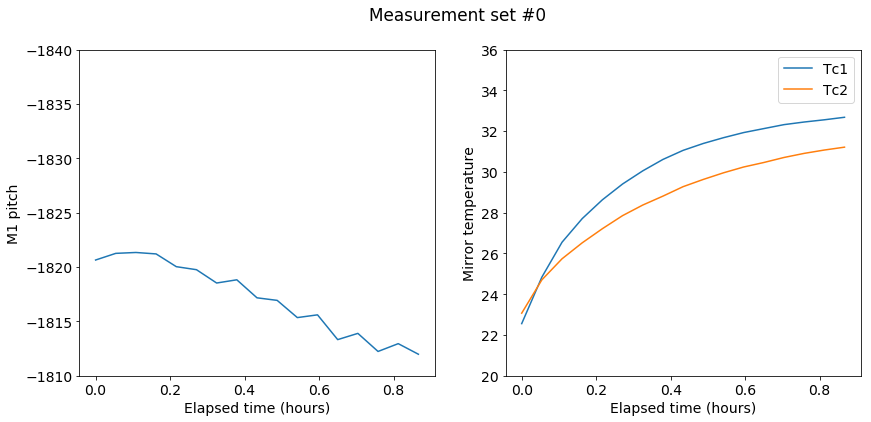

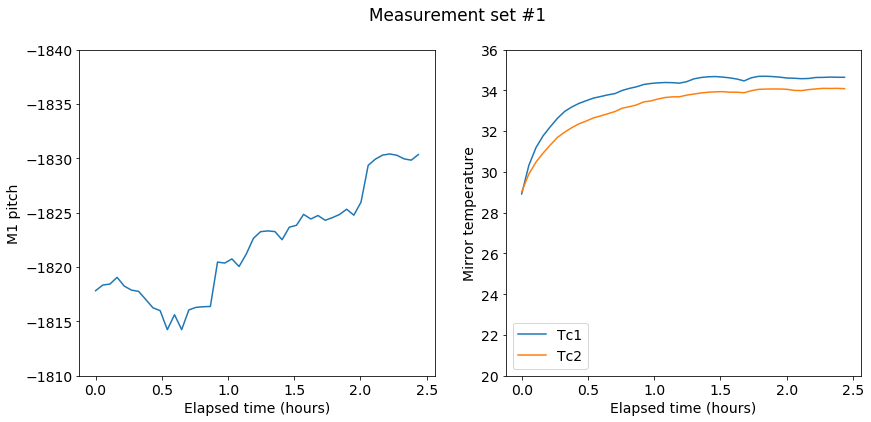

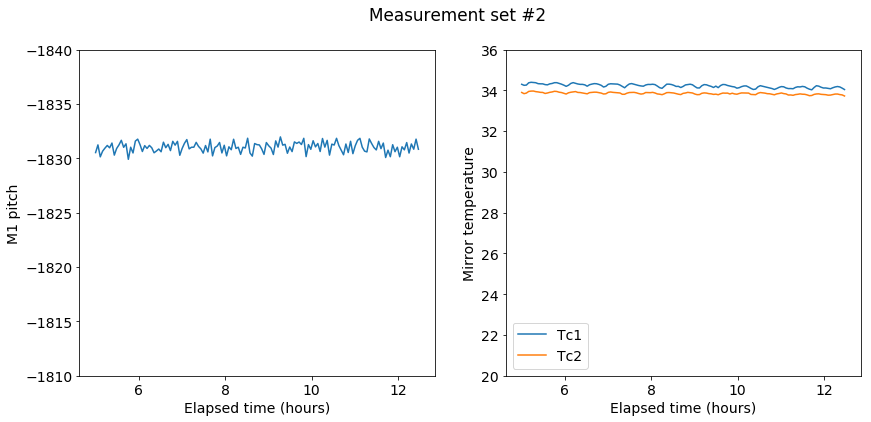

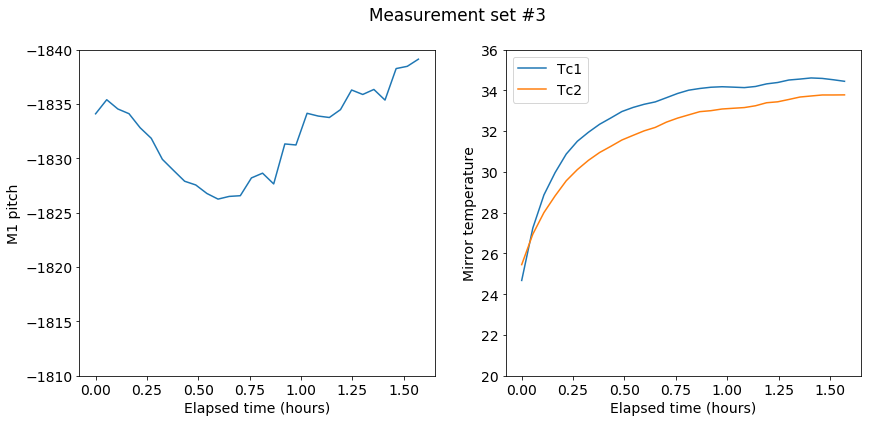

In [90]:

for ii in [0,1,2,3]:
    fig=plt.figure(figsize=(14,6))
    plt.suptitle("Measurement set #{}".format(ii))
    plt.subplot(1,2,1)
    plt.plot(MeasurementSet[ii]["elapsedTime"],MeasurementSet[ii]["M1"])
    plt.ylabel("M1 pitch")
    plt.xlabel("Elapsed time (hours)")
    plt.ylim([-1810,-1840])
    plt.subplot(1,2,2)
    plt.plot(MeasurementSet[ii]["elapsedTime"],MeasurementSet[ii]["Tc1"],label="Tc1")
    plt.plot(MeasurementSet[ii]["elapsedTime"],MeasurementSet[ii]["Tc2"],label="Tc2")
    plt.legend()
    plt.ylabel("Mirror temperature")
    plt.ylim([20,36])
    plt.xlabel("Elapsed time (hours)")
plt.show()

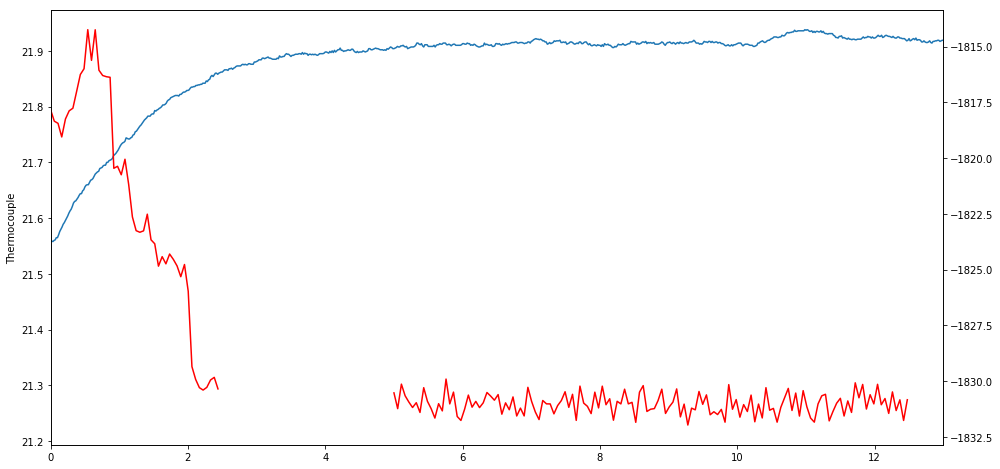

In [91]:
%matplotlib inline
fp=open("Data/tc_log.csv",'r')
timeStamp=[]
Tc=[]
Tc.append([])
Tc.append([])
Tc.append([])
Tc.append([])

next(fp)
lineNumber=0
for line in fp:
    lineNumber+=1
    if lineNumber>5.475e3:
        data=line.replace('"','').replace('\n','').split(',')
        for ii in range(4):
            Tc[ii].append(float(data[ii+1]))
fp.close()

readingNumber = [ii/60 for ii in range(len(Tc[0]))]

fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(readingNumber,Tc[0])
ax1.set_ylabel("Thermocouple")
ax1.set_xlim(0,13)
ax2=ax1.twinx()
ax2.plot(MeasurementSet[1]["elapsedTime"],MeasurementSet[1]["M1"],'r-')
ax2.plot(MeasurementSet[2]["elapsedTime"],MeasurementSet[2]["M1"],'r-')
plt.show()

# Pitch vs gap

------------ EPU gap = 32, hv = 28.3------------
position= -1839.4464705887765


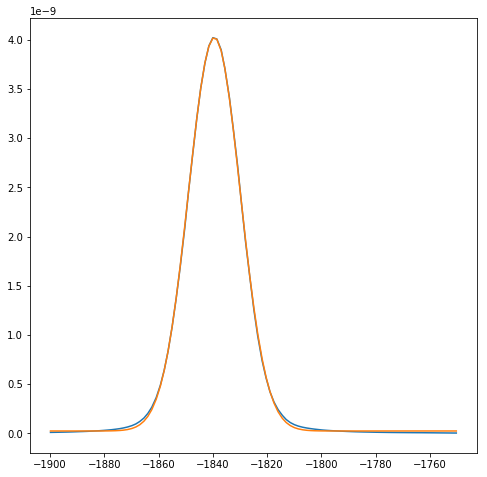

------------ EPU gap = 33, hv = 30.3------------
position= -1837.7548878997593


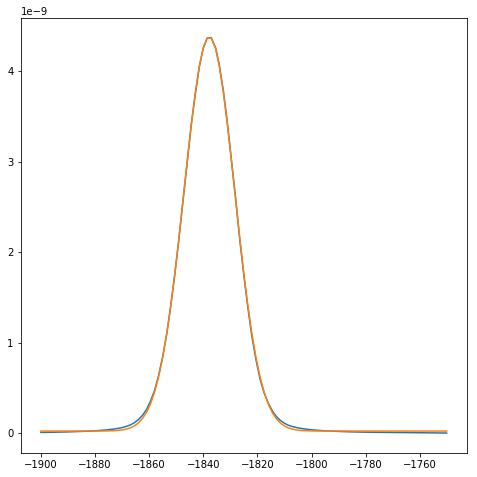

------------ EPU gap = 34, hv = 32.5------------
position= -1837.4092060534433


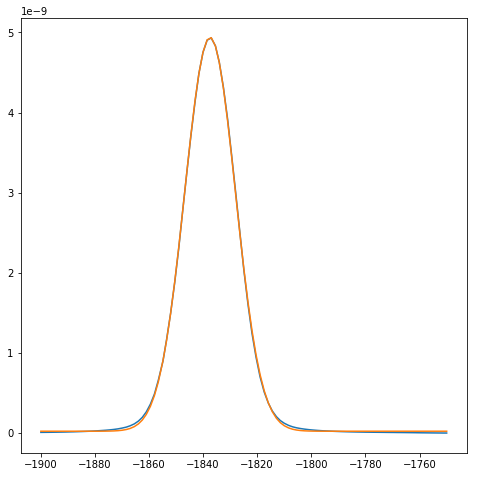

------------ EPU gap = 35, hv = 34.8------------
position= -1835.6178955094347


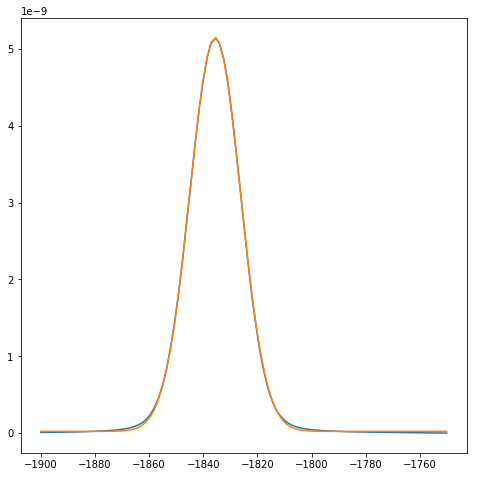

------------ EPU gap = 36, hv = 37.3------------
position= -1835.022825065123


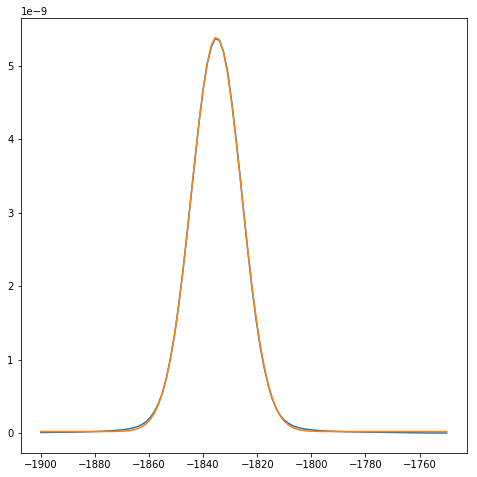

------------ EPU gap = 37, hv = 39.8------------
position= -1833.548625139522


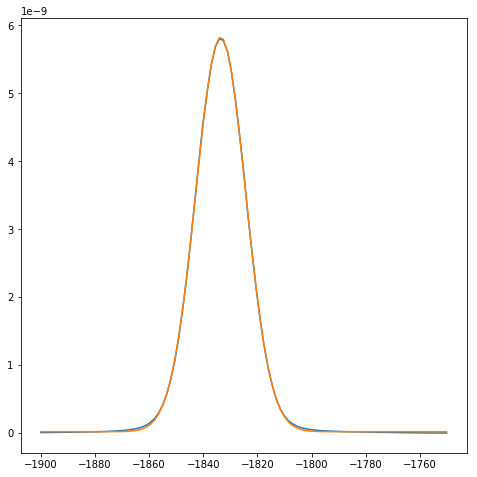

------------ EPU gap = 38, hv = 42.6------------
position= -1833.1353323785065


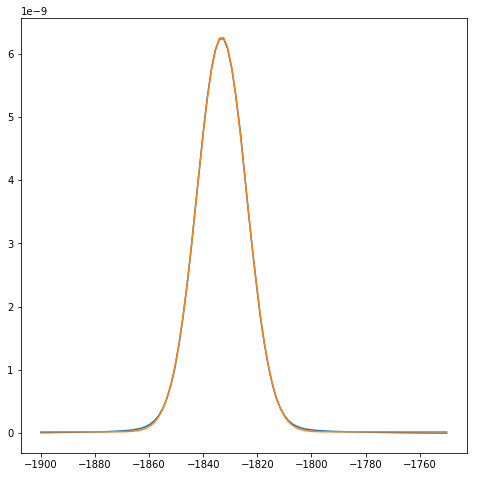

------------ EPU gap = 39, hv = 45.5------------
position= -1831.8119099763428


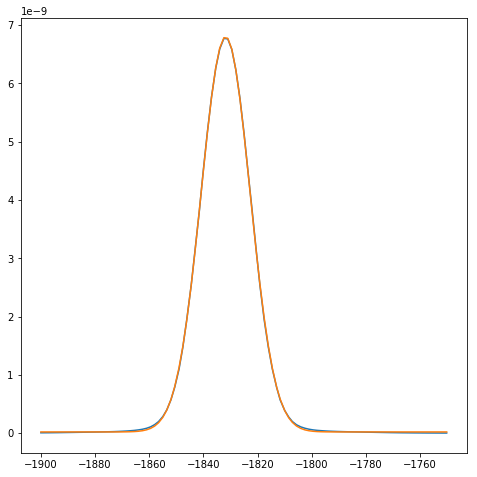

------------ EPU gap = 40, hv = 48.5------------
position= -1831.4791991566944


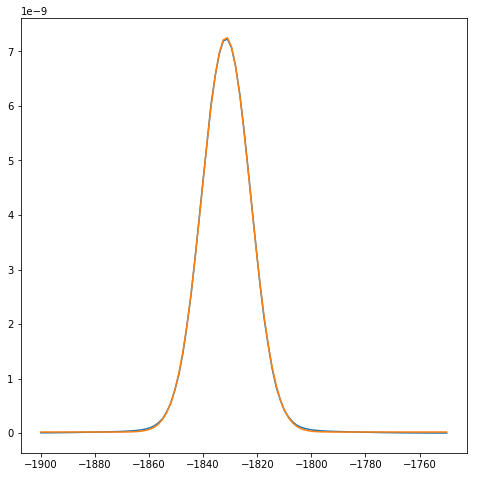

------------ EPU gap = 41, hv = 51.7------------
position= -1830.7342824905504


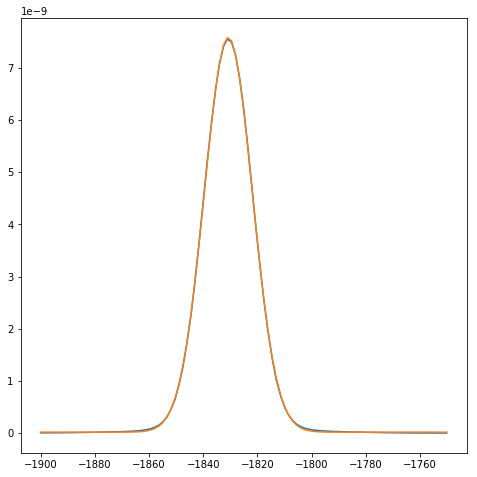

------------ EPU gap = 42, hv = 55.0------------
position= -1830.3183259036773


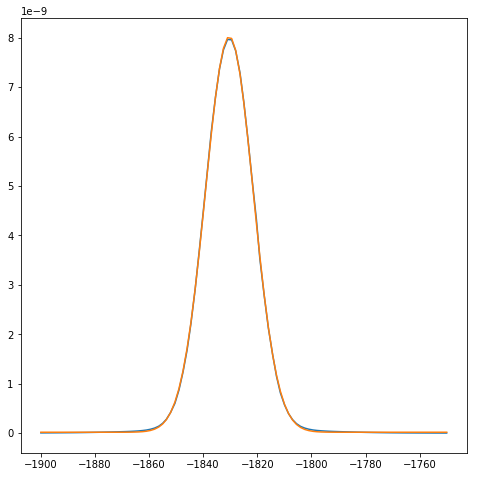

------------ EPU gap = 43, hv = 58.5------------
position= -1828.7898856749198


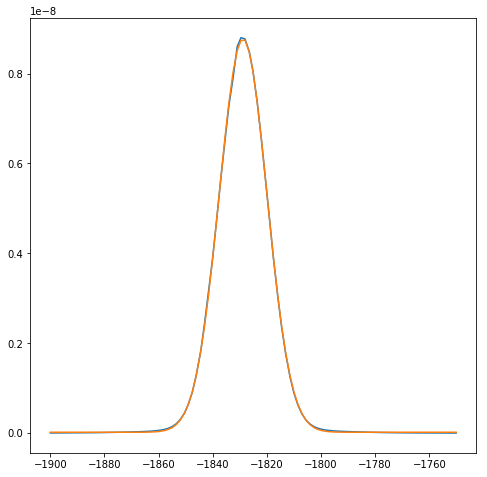

------------ EPU gap = 44, hv = 62.2------------
position= -1828.5304221451695


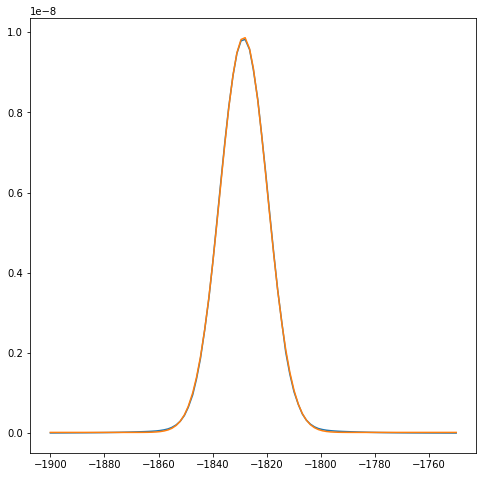

------------ EPU gap = 45, hv = 65.9------------
position= -1827.37034100796


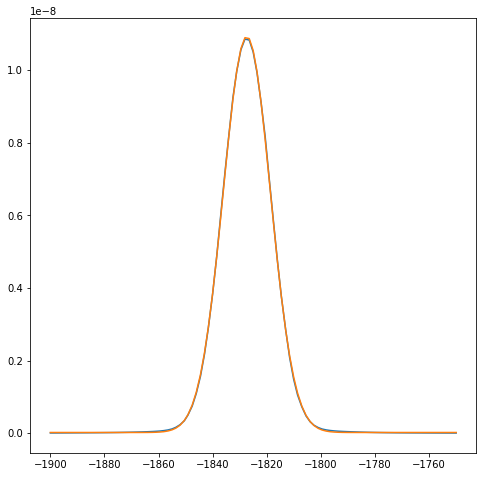

------------ EPU gap = 46, hv = 69.9------------
position= -1827.2032662411048


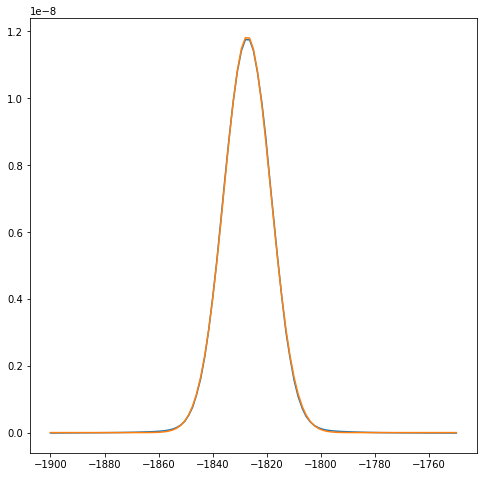

------------ EPU gap = 47, hv = 74.0------------
position= -1826.0140943137774


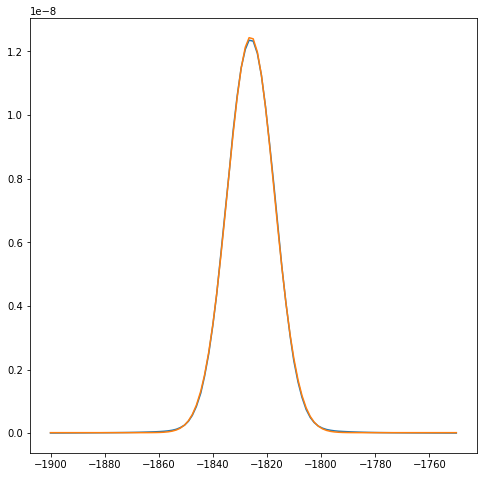

------------ EPU gap = 48, hv = 78.2------------
position= -1826.0009447764864


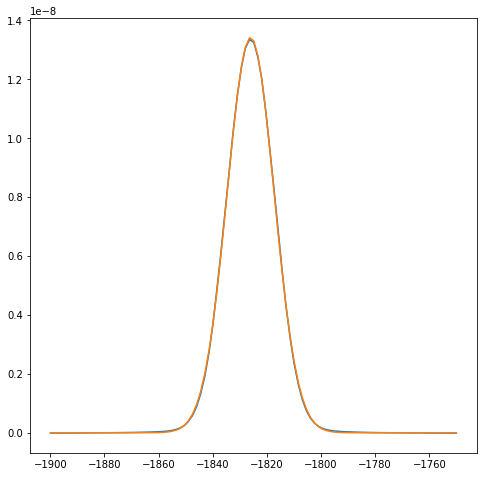

------------ EPU gap = 49, hv = 82.6------------
position= -1824.5797173365595


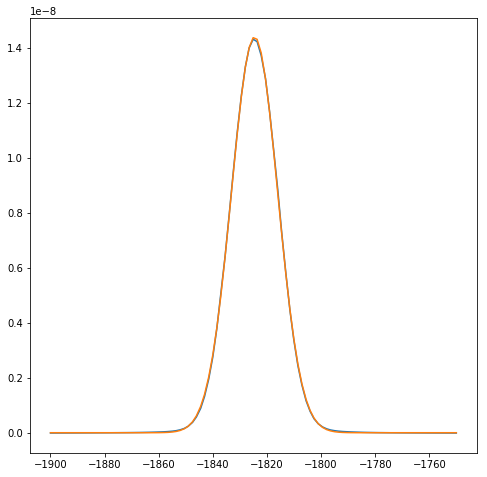

------------ EPU gap = 50, hv = 87.1------------
position= -1824.865879893374


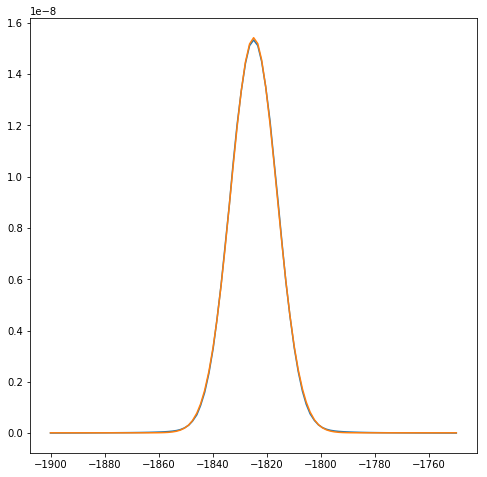

------------ EPU gap = 51, hv = 91.7------------
position= -1822.3297028823933


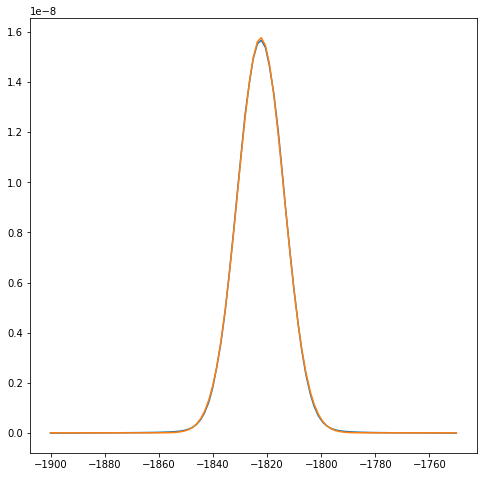

------------ EPU gap = 52, hv = 96.4------------
position= -1822.4615165038595


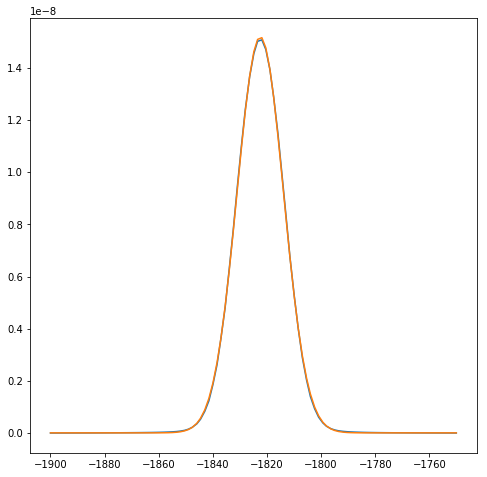

------------ EPU gap = 53, hv = 101.2------------
position= -1820.9078134768763


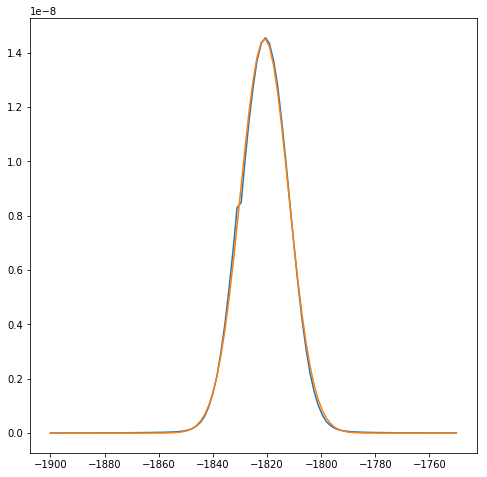

------------ EPU gap = 54, hv = 106.0------------
position= -1820.7222682365957


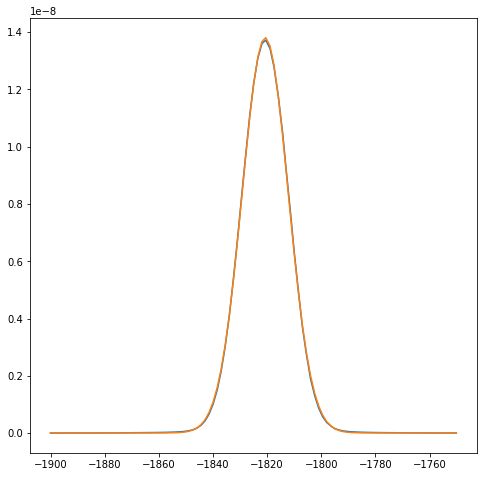

------------ EPU gap = 55, hv = 110.9------------
position= -1819.9663293259987


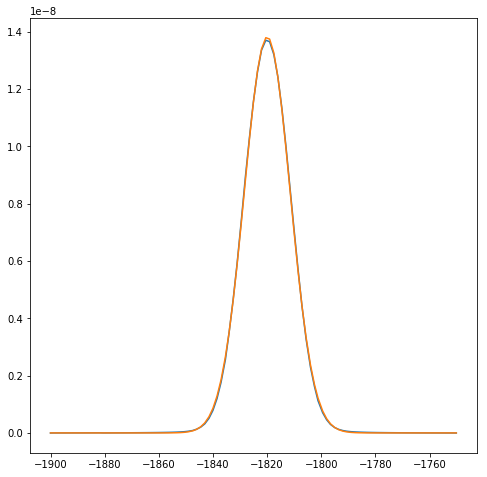

------------ EPU gap = 56, hv = 115.8------------
position= -1818.9760171996572


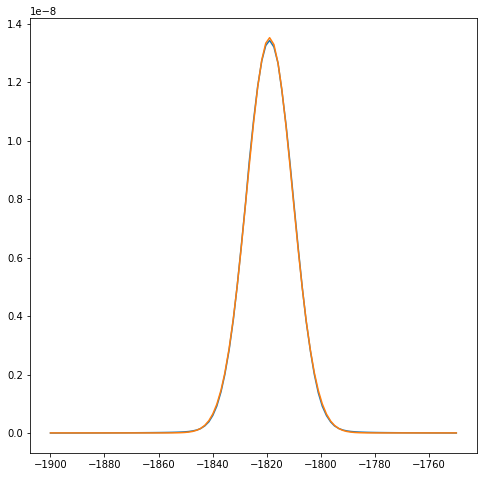

------------ EPU gap = 57, hv = 120.8------------
position= -1818.4068292211214


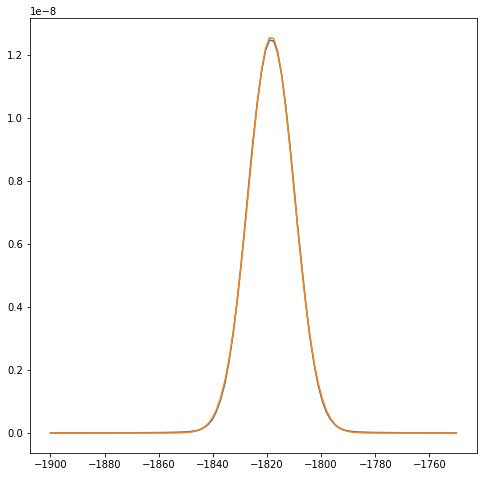

------------ EPU gap = 58, hv = 125.8------------
position= -1818.7159077870338


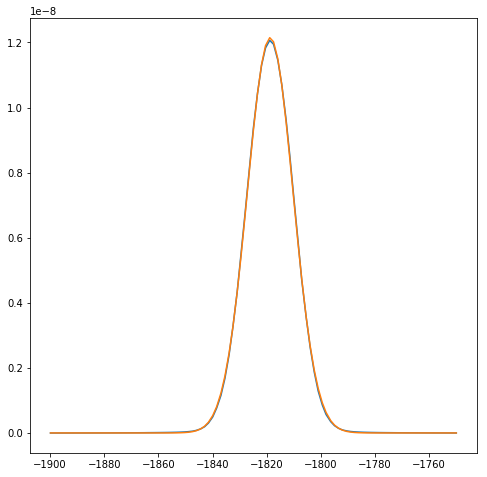

------------ EPU gap = 59, hv = 130.8------------
position= -1816.9019823735912


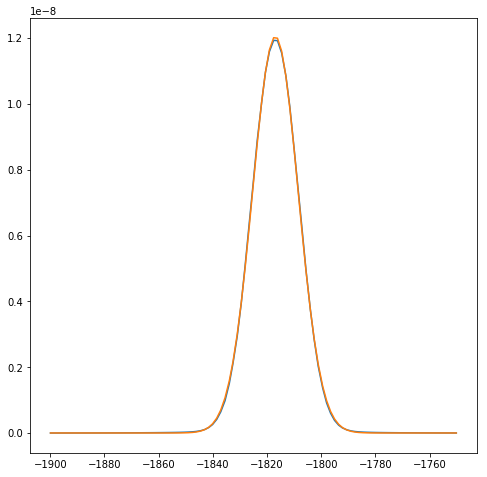

------------ EPU gap = 60, hv = 135.8------------
position= -1817.9303915494938


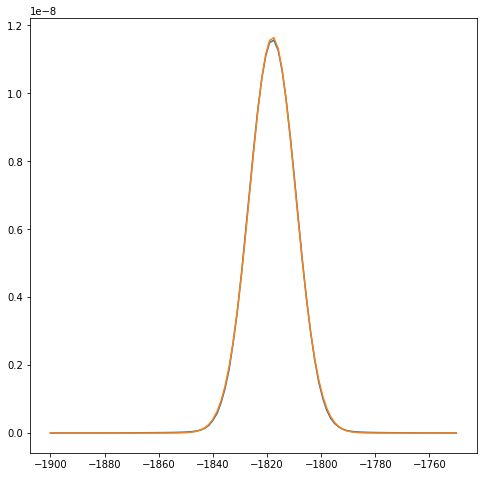

------------ EPU gap = 61, hv = 140.7------------
position= -1817.0469766736003


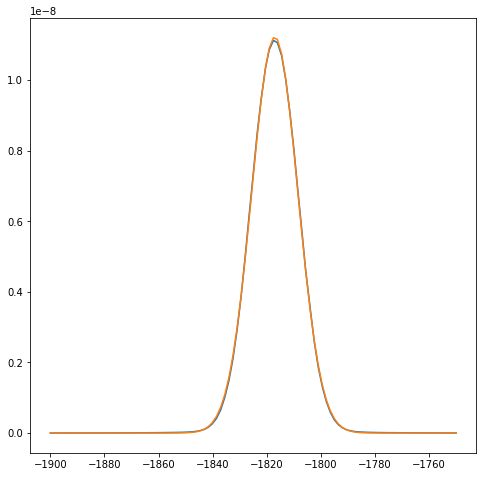

------------ EPU gap = 62, hv = 145.6------------
position= -1815.7412900118698


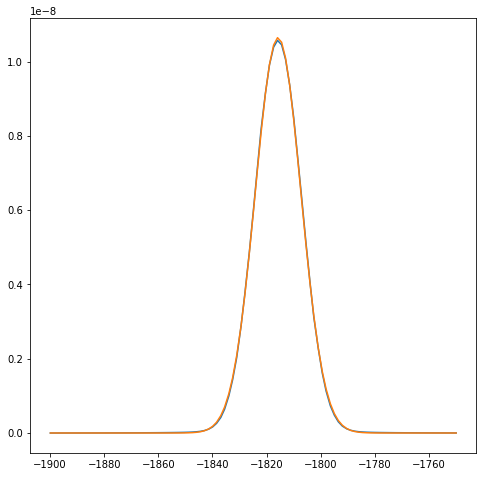

------------ EPU gap = 63, hv = 150.4------------
position= -1815.3412153593965


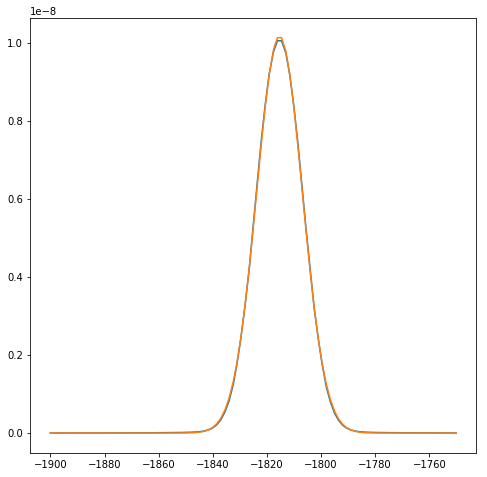

------------ EPU gap = 64, hv = 155.2------------
position= -1815.535789119601


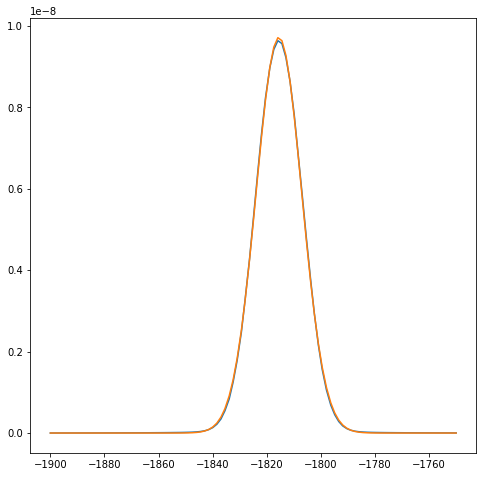

------------ EPU gap = 65, hv = 159.8------------
position= -1814.8665914965454


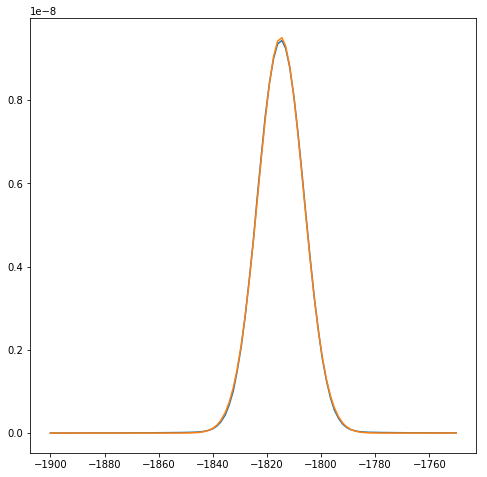

------------ EPU gap = 66, hv = 164.3------------
position= -1814.0067265934583


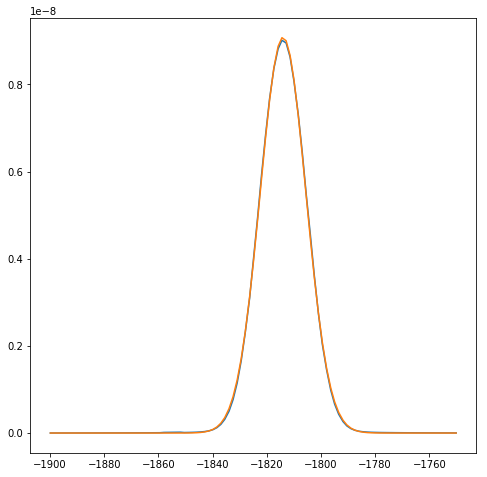

------------ EPU gap = 67, hv = 168.7------------
position= -1813.4646562843718


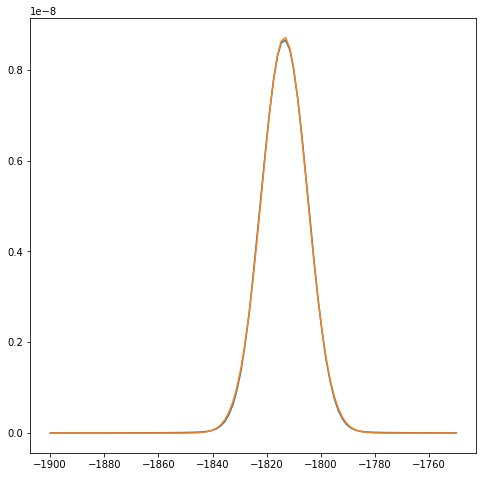

------------ EPU gap = 68, hv = 173.0------------
position= -1813.8800511969935


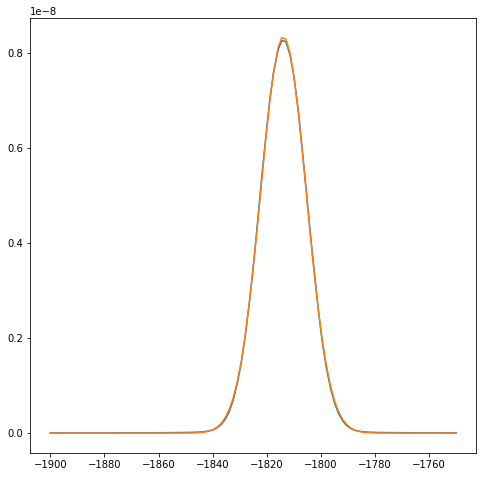

------------ EPU gap = 69, hv = 177.2------------
position= -1813.3738455906407


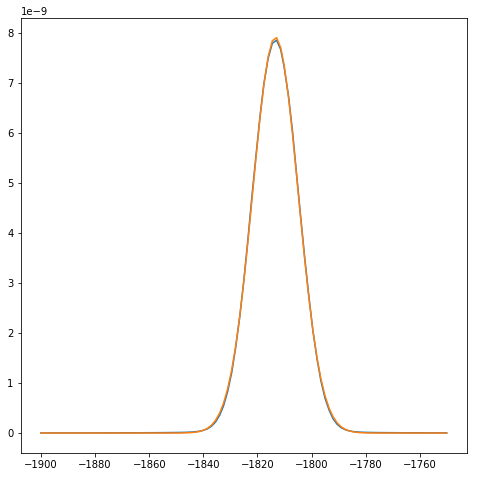

------------ EPU gap = 70, hv = 181.4------------
position= -1813.7642083464102


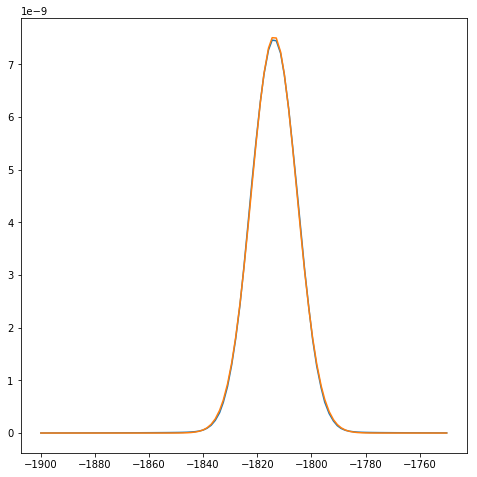

------------ EPU gap = 71, hv = 185.3------------
position= -1811.7840623902491


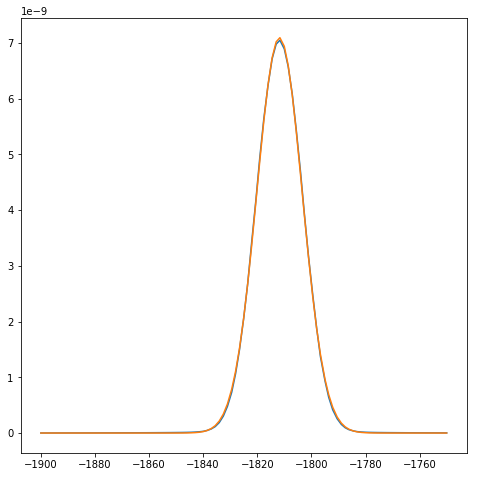

------------ EPU gap = 72, hv = 189.0------------
position= -1812.288675453421


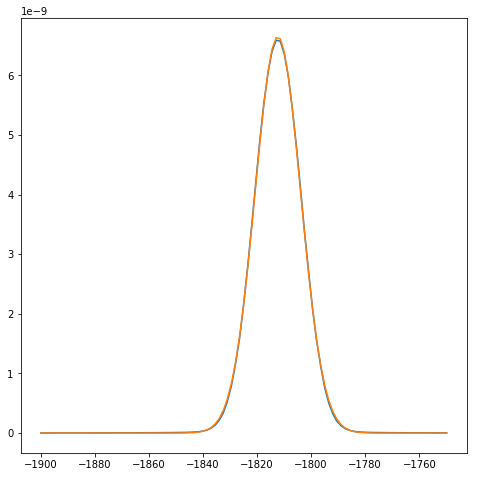

------------ EPU gap = 73, hv = 192.7------------
position= -1811.8059748006106


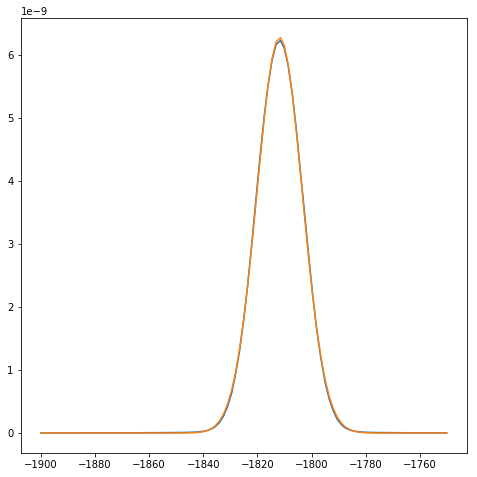

------------ EPU gap = 74, hv = 196.1------------
position= -1812.9329722435352


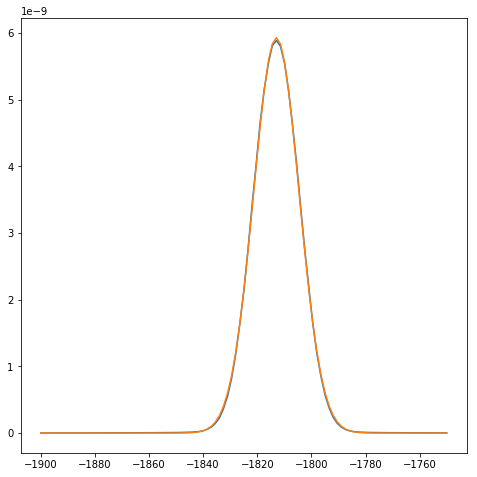

------------ EPU gap = 75, hv = 199.4------------
position= -1811.756084970771


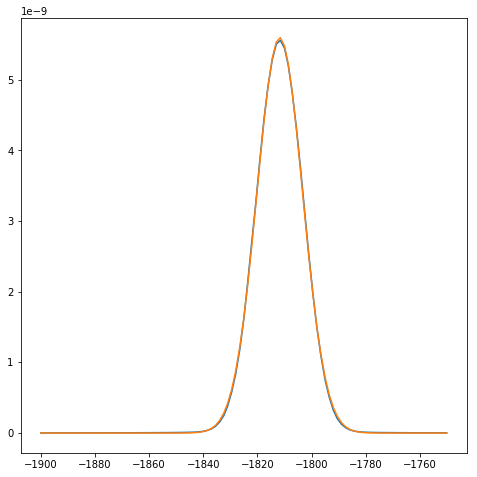

------------ EPU gap = 76, hv = 202.5------------
position= -1812.1924785855385


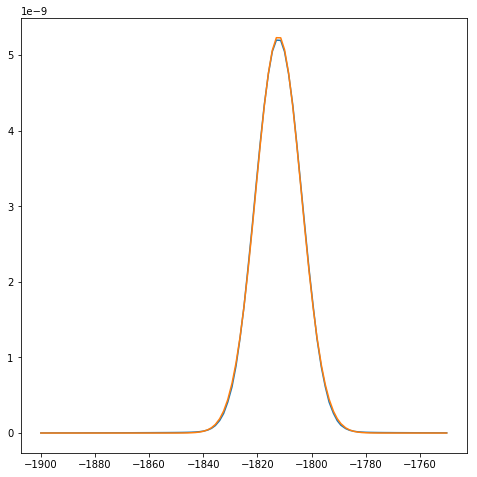

------------ EPU gap = 77, hv = 205.5------------
position= -1811.9675160582353


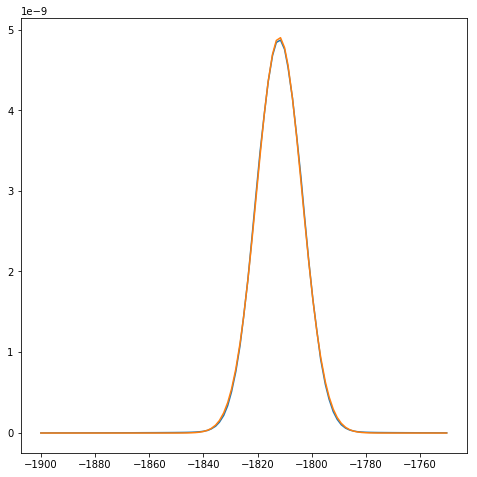

------------ EPU gap = 78, hv = 208.3------------
position= -1810.7265306446618


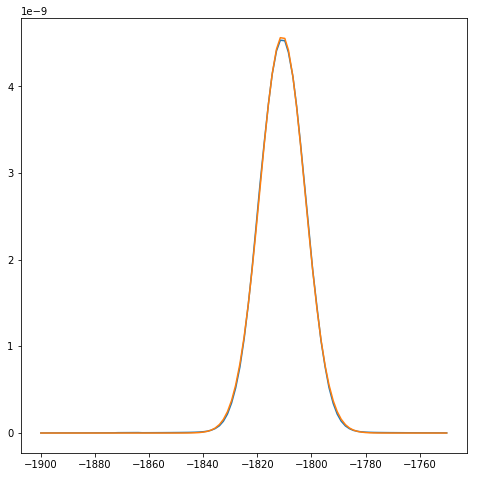

------------ EPU gap = 79, hv = 211.0------------
position= -1810.1379903695718


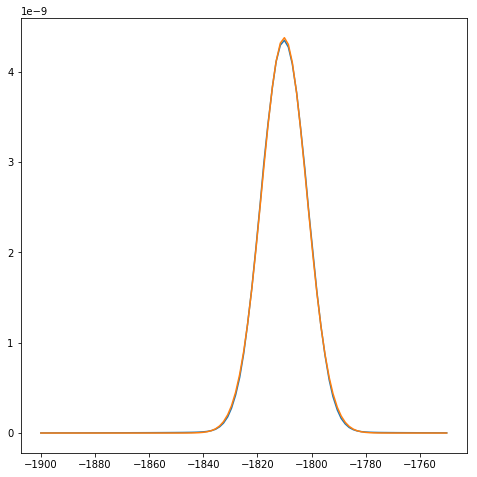

------------ EPU gap = 80, hv = 213.5------------
position= -1810.7346218608855


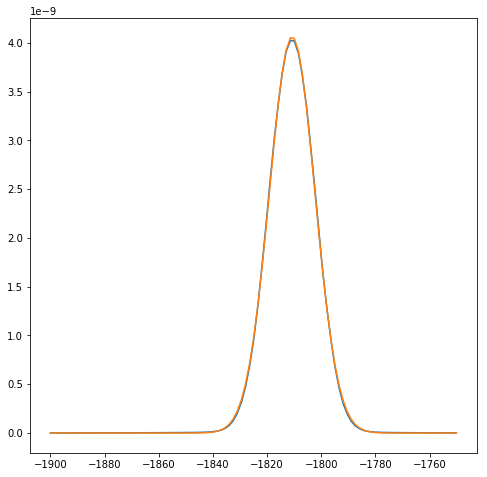

------------ EPU gap = 81, hv = 215.9------------
position= -1810.1797979800454


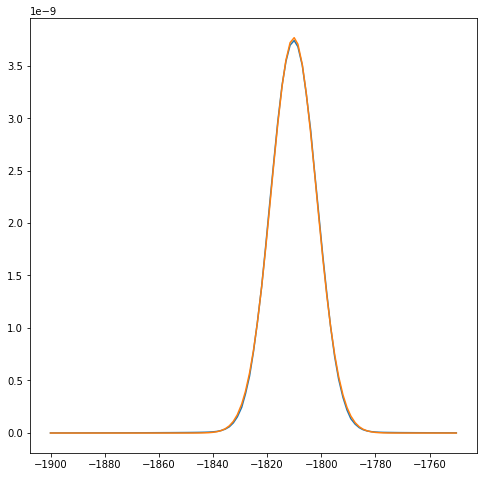

------------ EPU gap = 82, hv = 218.1------------
position= -1810.6571756108528


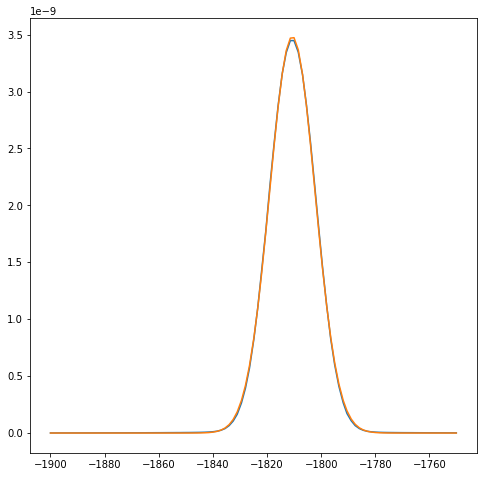

------------ EPU gap = 83, hv = 220.3------------
position= -1810.230186794014


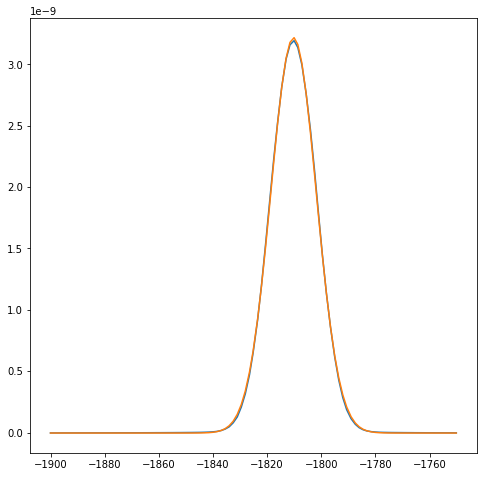

------------ EPU gap = 84, hv = 222.3------------
position= -1810.695088970845


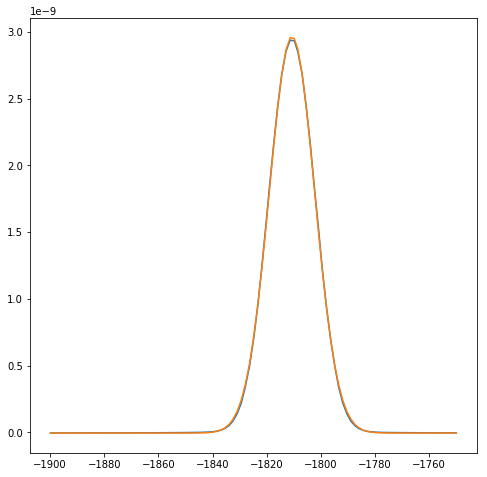

------------ EPU gap = 85, hv = 224.2------------
position= -1810.2142405034563


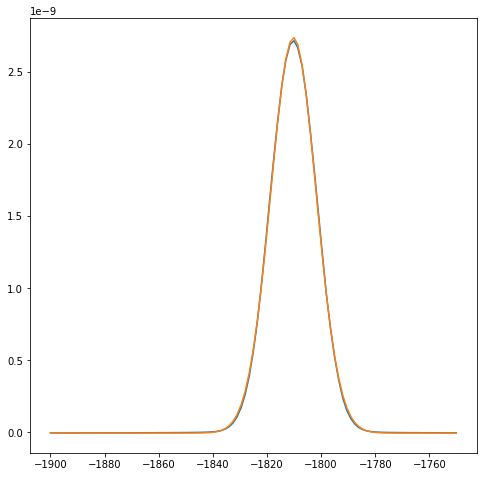

------------ EPU gap = 86, hv = 225.9------------
position= -1810.7288130041075


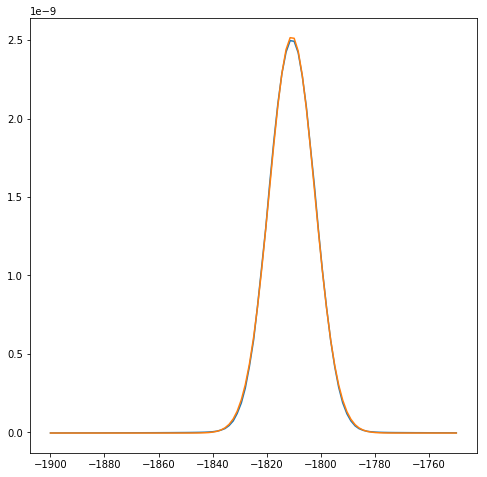

------------ EPU gap = 87, hv = 228.0------------
position= -1810.2176796626084


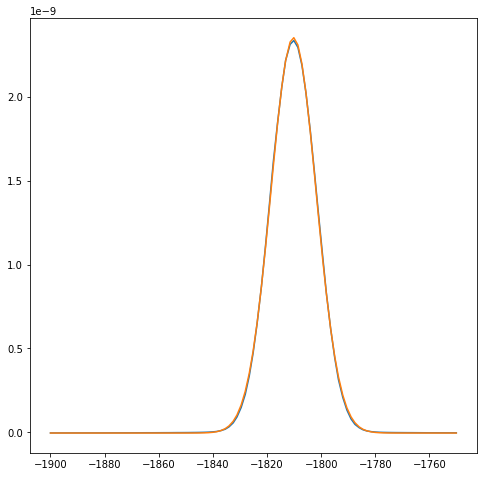

------------ EPU gap = 88, hv = 230.0------------
position= -1810.6547077916161


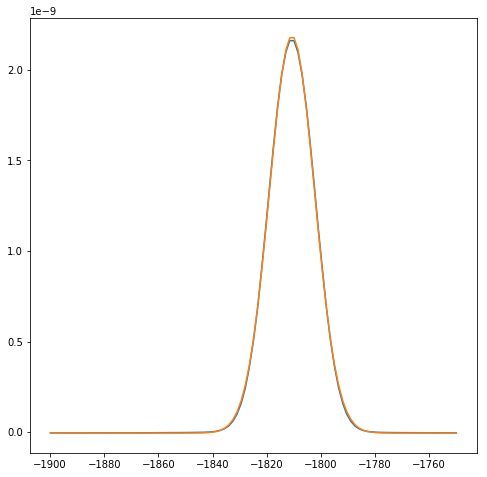

In [92]:
m1_pitch = []
EPU_gap = []
photonEnergy = []


t1,t2,t3 = fitGaussToGapSet('(2019.02.28)_M1_pitch_vs_EPUgap.h5',725,737,showPlots=False)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

t1,t2,t3 = fitGaussToGapSet('(2019.02.28)_M1_pitch_vs_EPUgap2.h5',739,795,showPlots=True)
for index,element in enumerate(t1):
    EPU_gap.append(t1[index])
    photonEnergy.append(t2[index])
    m1_pitch.append(t3[index])

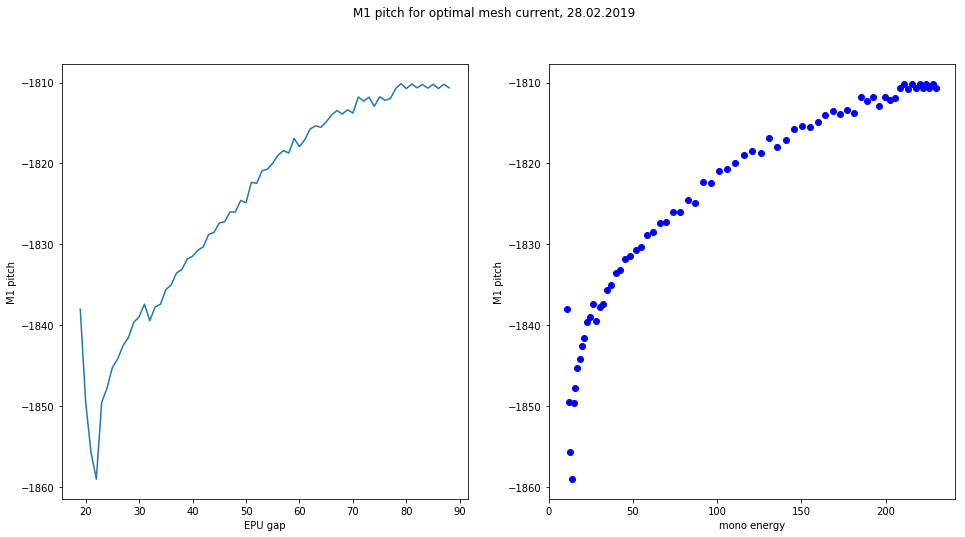

In [93]:
fig=plt.figure(figsize=(16,8))
plt.suptitle('M1 pitch for optimal mesh current, 28.02.2019')
plt.subplot(1,2,1)
plt.xlabel("EPU gap")
plt.ylabel("M1 pitch")
plt.plot(EPU_gap,m1_pitch)
plt.subplot(1,2,2)
plt.xlabel("mono energy")
plt.ylabel("M1 pitch")
plt.plot(photonEnergy,m1_pitch,'bo')
plt.show()

In [ ]:
for energy,pitch in zip(photonEnergy,m1_pitch):
    print("{:.1f}\t{:.1f}".format(energy,pitch))

## 

In [2]:
(2.2-3.5)/2

-0.6499999999999999

# Time series

In [85]:
HDF5info(path="Data/(2019.03.06)_M1_vs_time_gap19HPOL.h5")


Data/(2019.03.06)_M1_vs_time_gap19HPOL.h5 contains 44 scans:
(I am stripping off the 'entry' part of their name)


Scan index	 # datasets 	 # points in first dataset
----------------------------------------------------------
1419		16		121
1420		16		121
1421		16		121
1422		16		121
1423		16		121
1424		16		121
1425		16		121
1426		16		121
1427		16		121
1428		16		121
1429		16		121
1430		16		121
1431		16		121
1432		16		121
1433		16		121
1434		16		121
1435		16		121
1436		16		121
1437		16		121
1438		16		121
1439		16		121
1440		16		121
1441		16		121
1442		16		121
1443		16		121
1444		16		121
1445		16		121
1446		16		121
1447		16		121
1448		16		121
1449		16		121
1450		16		121
1451		16		121
1452		16		121
1453		16		121
1454		16		121
1455		16		121
1456		16		121
1457		16		121
1458		16		121
1459		16		121
1460		16		121
1461		16		121
1462		16		50


position= -1851.900750345097


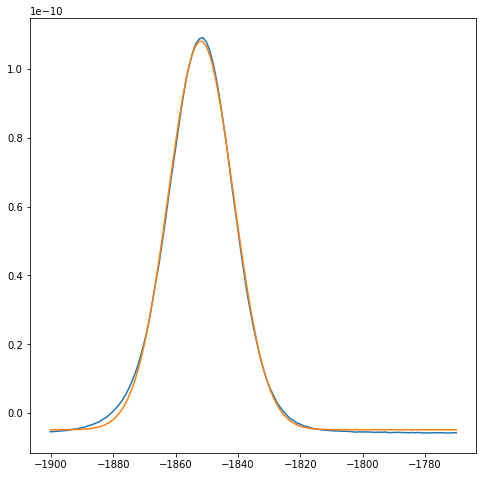

position= -1851.953888349596


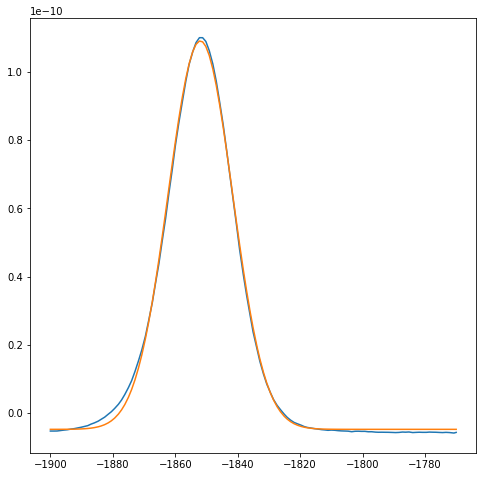

position= -1850.7471811418586


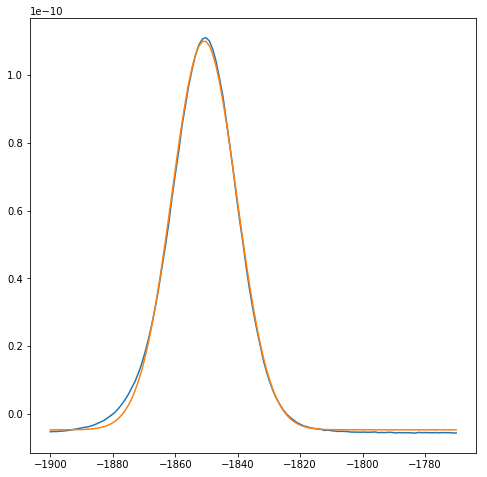

position= -1848.2179716526664


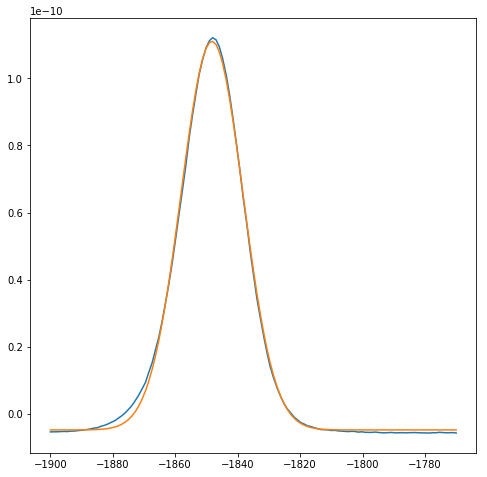

position= -1845.8327512730273


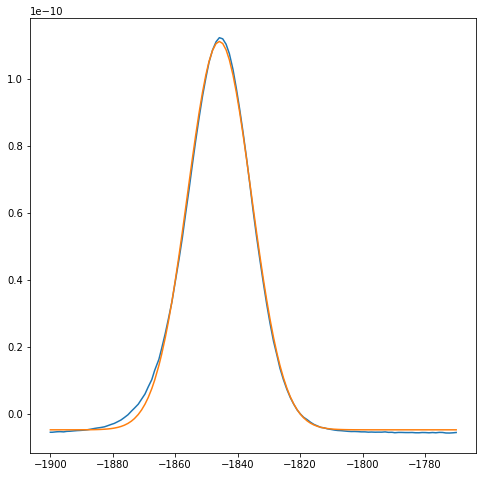

position= -1843.7126736042994


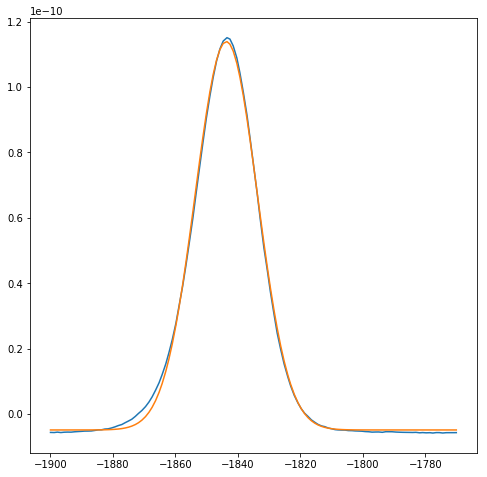

position= -1842.290387677897


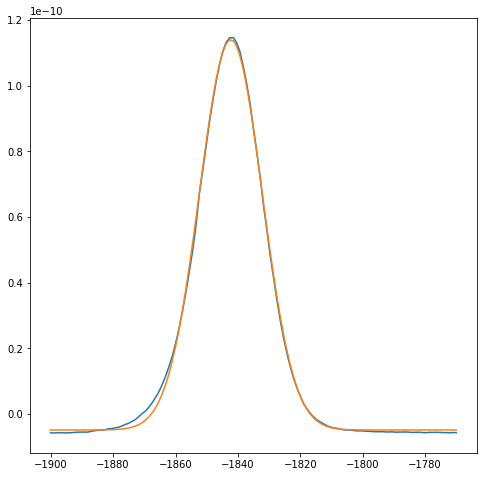

position= -1842.6044417523613


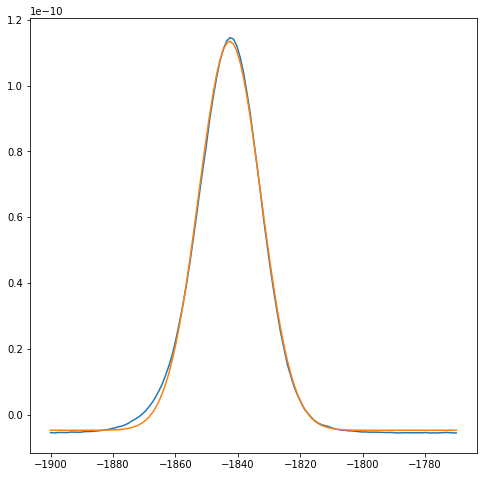

position= -1842.1646913223929


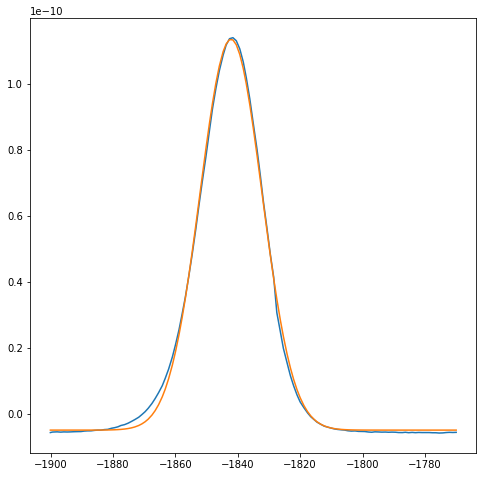

position= -1843.5663818329458


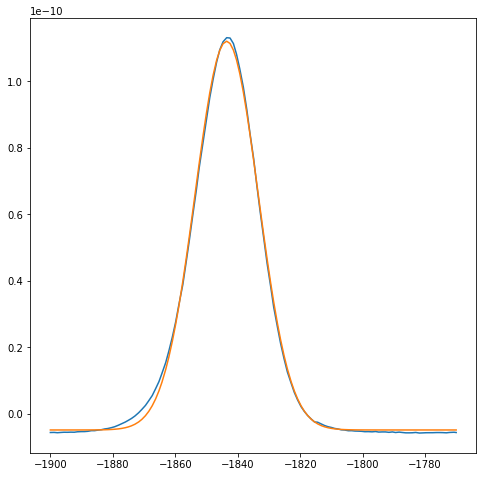

position= -1844.2448731254276


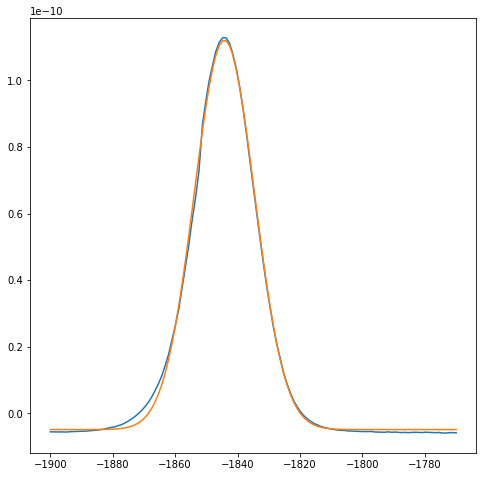

position= -1845.5785574761735


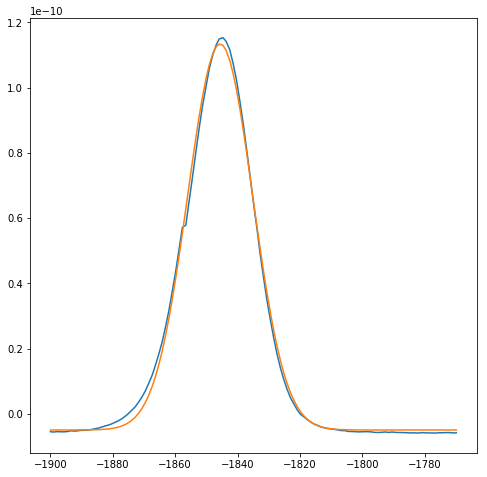

position= -1846.1784004644571


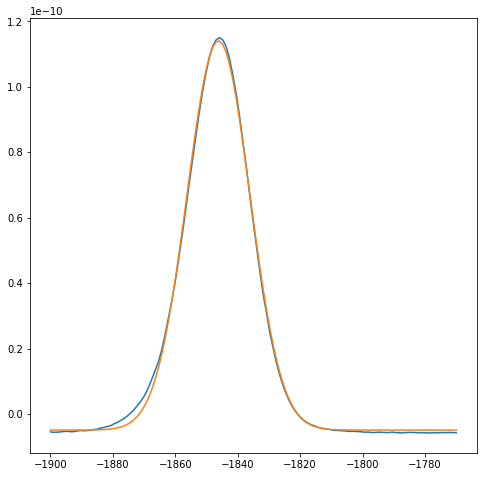

position= -1848.9242775088999


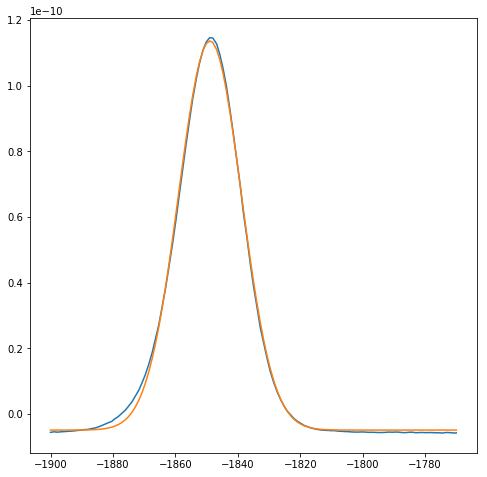

position= -1848.7868881184418


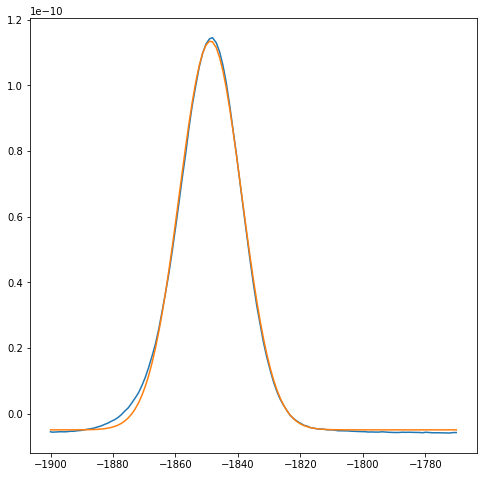

position= -1852.304979645272


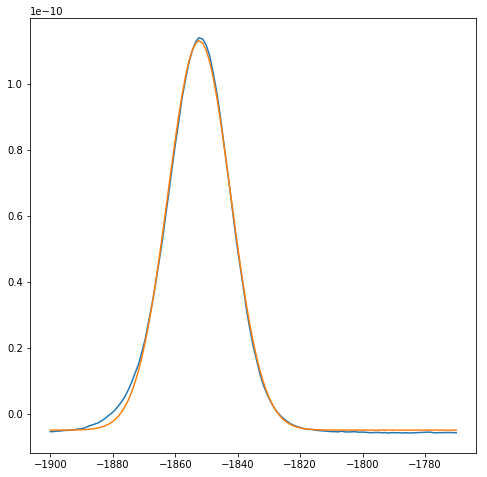

position= -1852.1832674473728


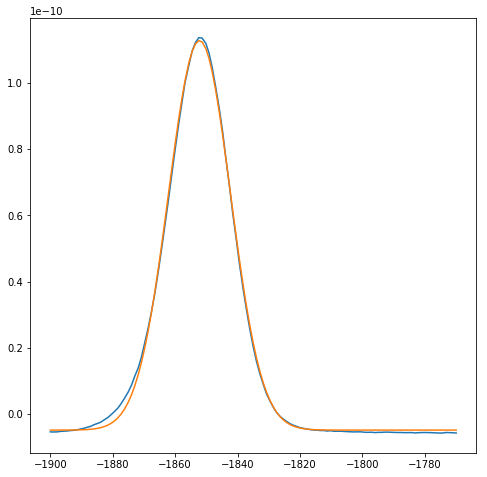

position= -1853.2033375690048


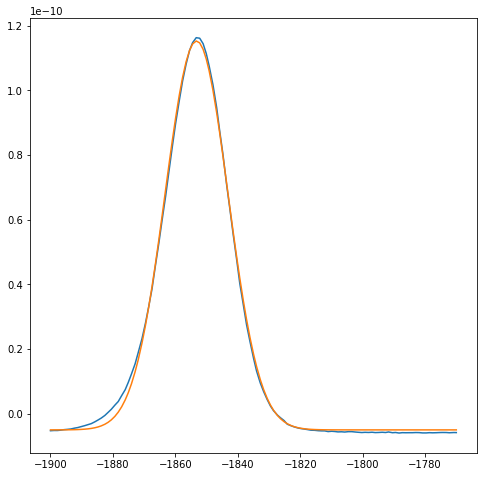

position= -1856.2859137724975


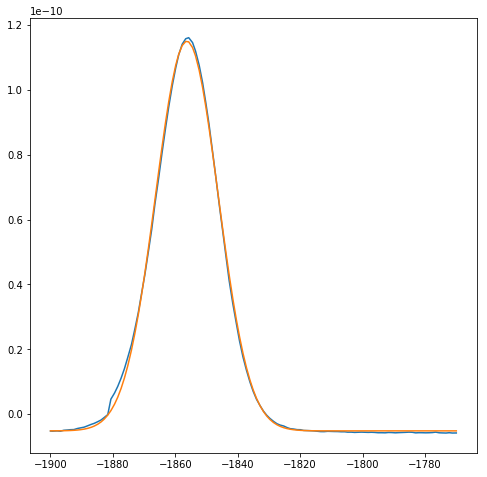

position= -1857.0666529147516


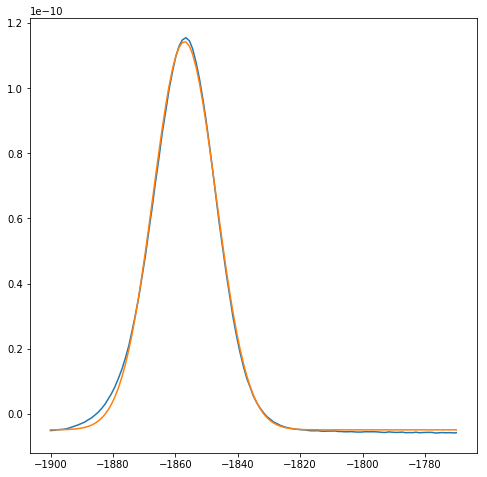

position= -1856.63477243665


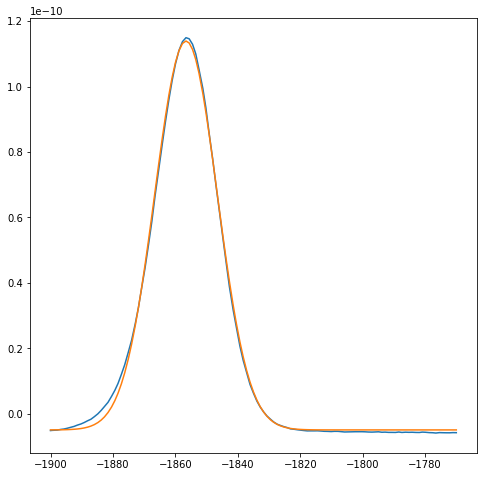

position= -1857.804281335766


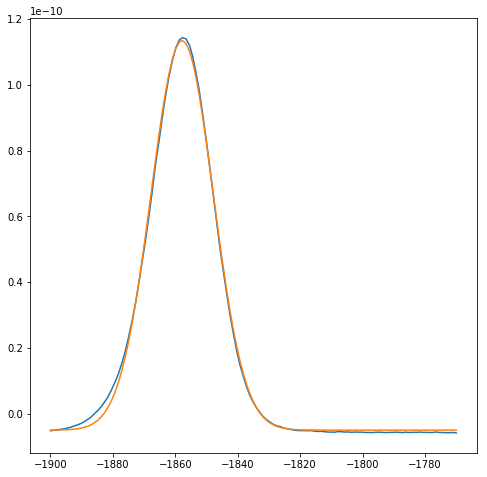

position= -1857.5683098818583


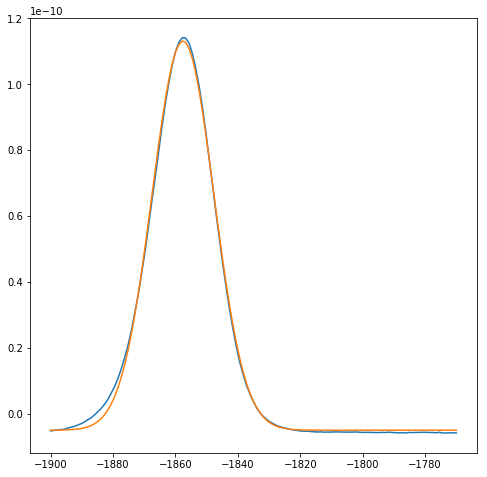

position= -1859.7992482849481


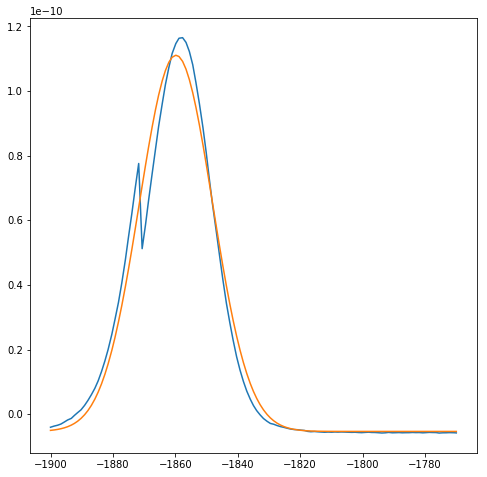

position= -1862.9056904874135


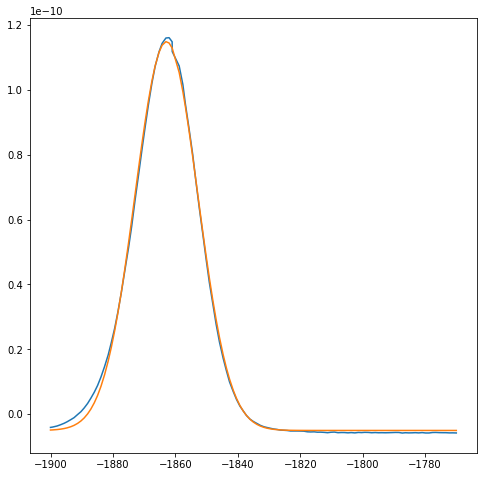

position= -1863.5208961513015


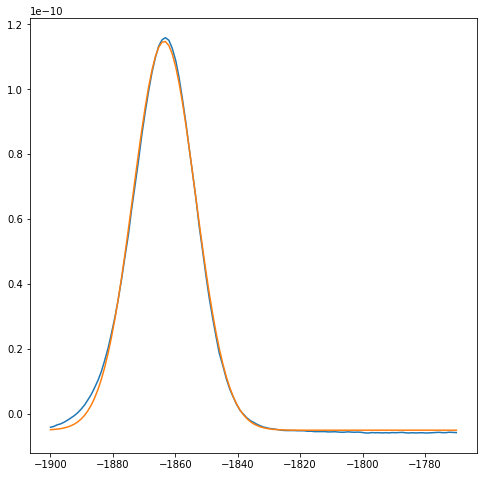

position= -1863.1265262628006


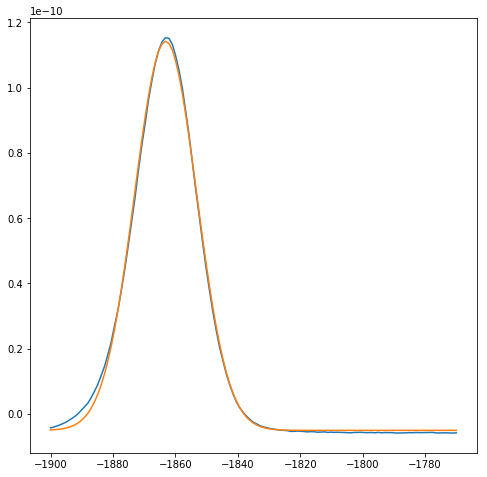

position= -1863.814477886973


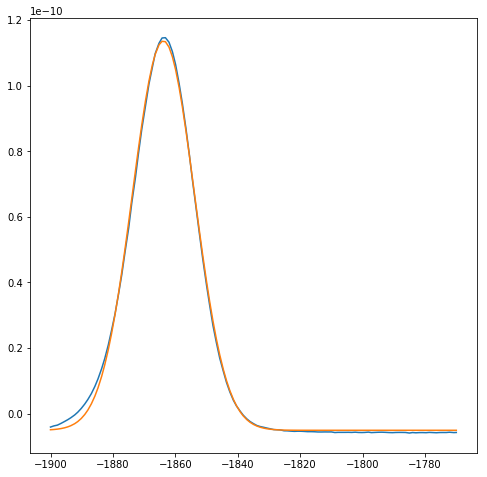

position= -1863.461926469241


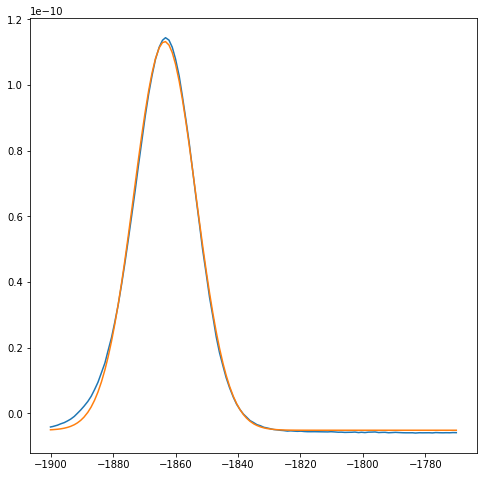

position= -1863.941726989784


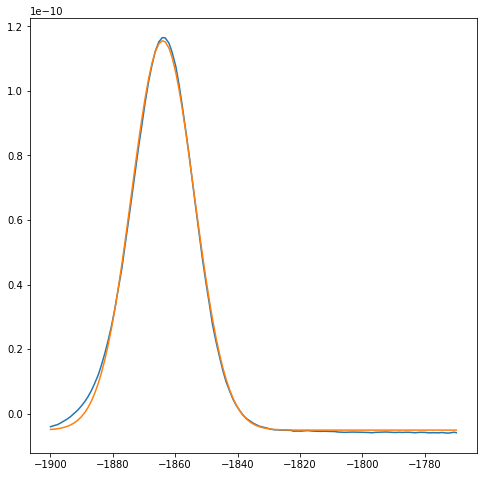

position= -1863.5590059012031


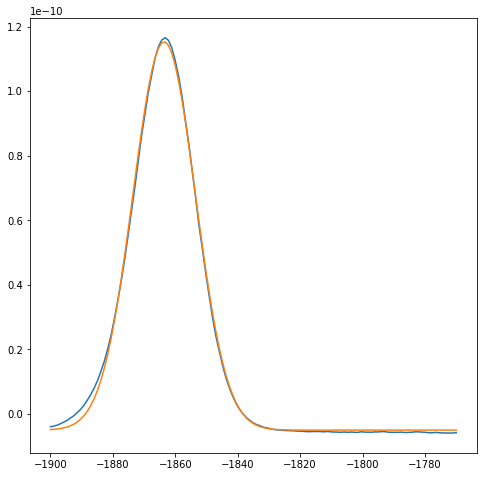

position= -1864.0576713041187


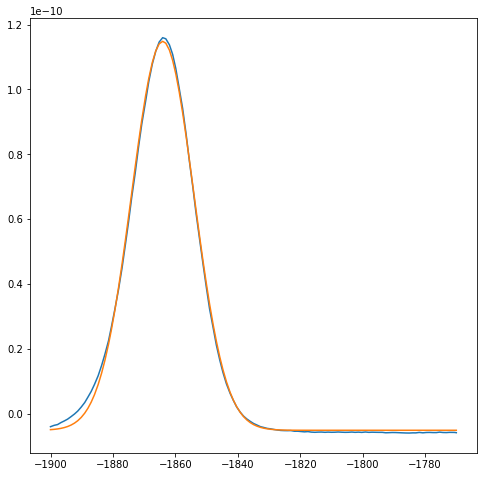

position= -1863.676296465547


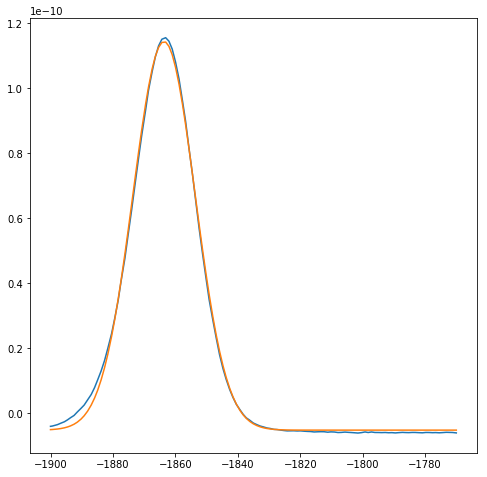

position= -1863.6572699938254


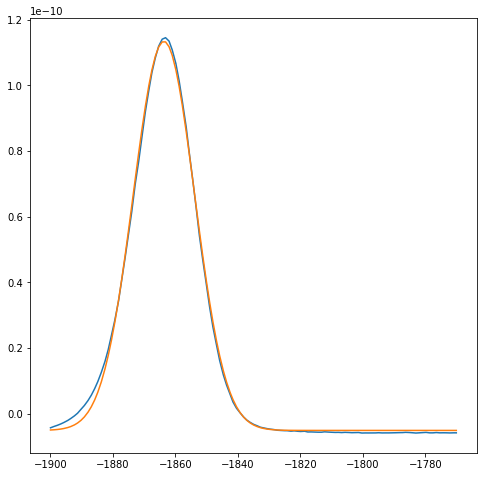

position= -1863.3717401284812


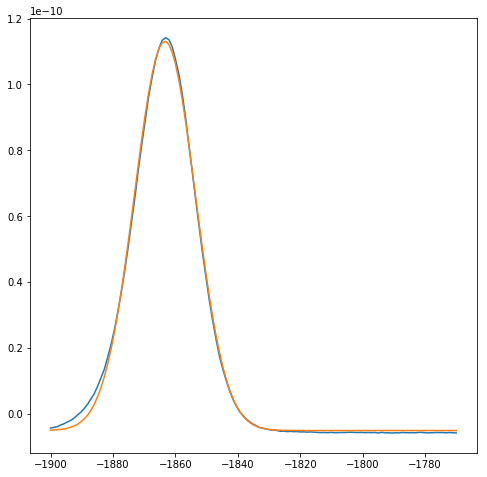

position= -1864.1421924263732


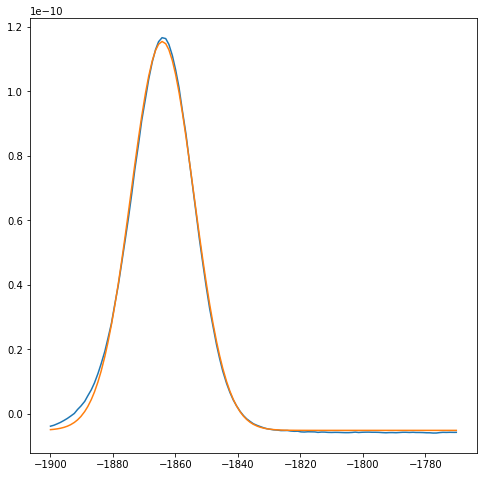

position= -1863.8895391952726


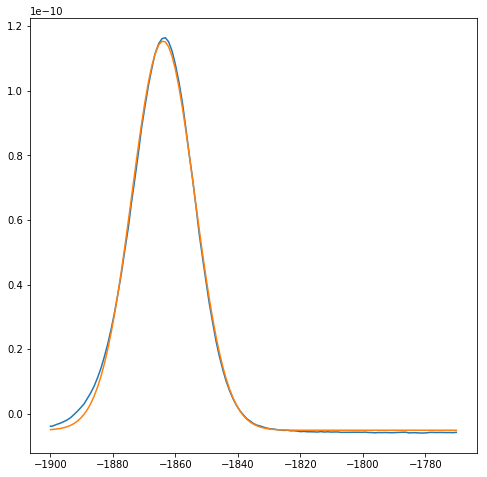

position= -1864.3638130298782


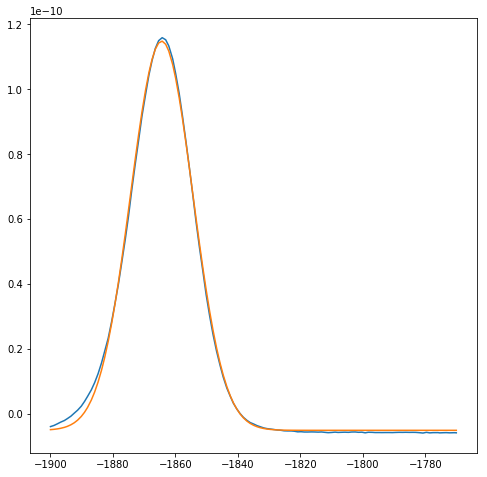

position= -1863.9047032101712


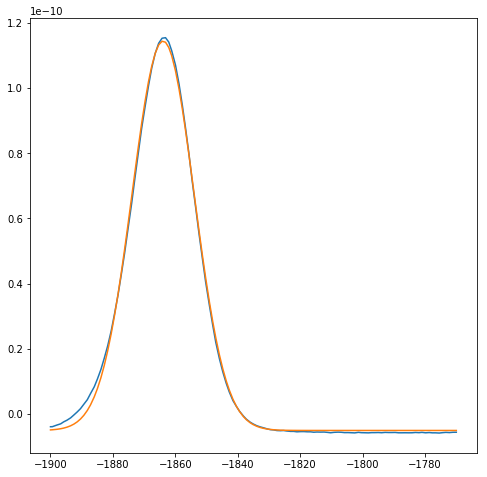

position= -1864.442227622385


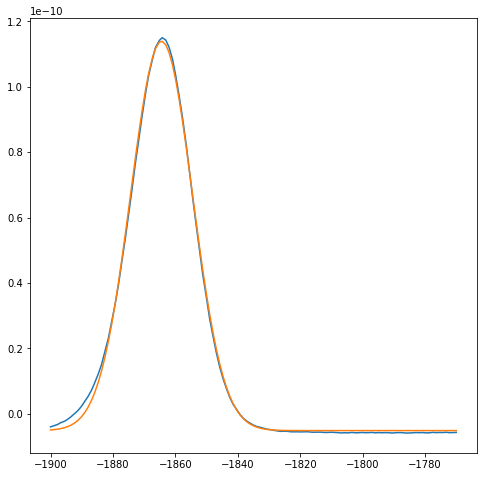

position= -1863.9357936989838


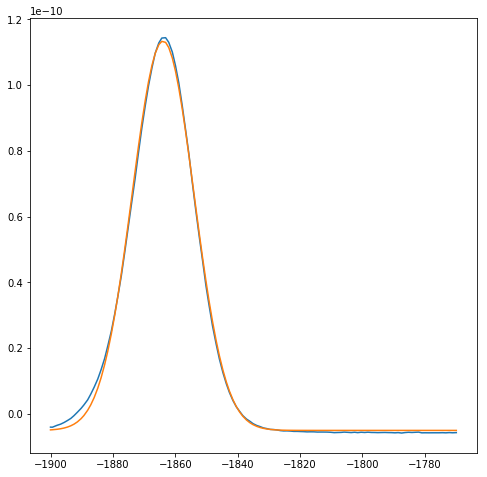

position= -1864.3469351328238


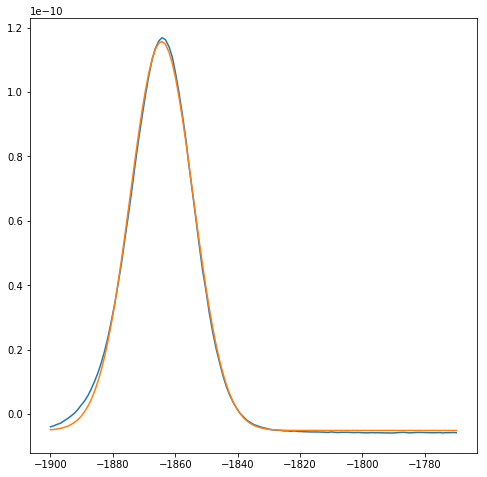

position= -1863.9183777977485


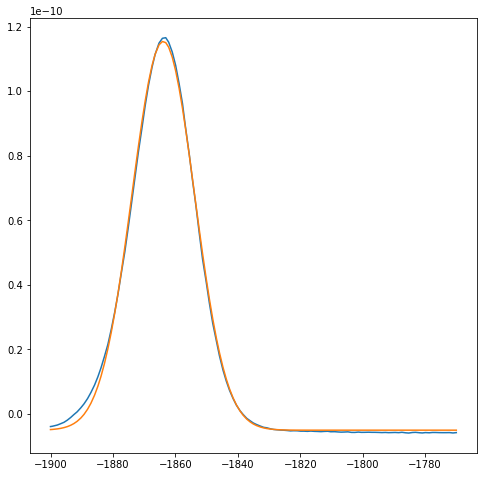

In [94]:
T1,T2,M1=fitGaussToMeshHVSet(filename='Data/(2019.03.06)_M1_vs_time_gap19HPOL.h5',firstScan=1419,lastScan=1461,showPlots=True)
scanNumber=[ii for ii,value in enumerate(M1)]
elapsedTime=[ii*((5)/60) for ii,value in enumerate(M1)]
MeasurementSet.append({"Tc1":T1,"Tc2":T2,"M1":M1,"scanNumber":scanNumber,"elapsedTime":elapsedTime})


In [95]:
%matplotlib inline
fp=open("Data/(2019.03.06)_M1_vs_time_thermocouples.csv",'r')
timeStamp=[]
Tc=[]
Tc.append([])
Tc.append([])
Tc.append([])
Tc.append([])

next(fp)
lineNumber=0
for line in fp:
    lineNumber+=1
    if lineNumber>1.815e3 and lineNumber<2.03e3:
        data=line.replace('"','').replace('\n','').split(',')
        for ii in range(4):
            Tc[ii].append(float(data[ii+1]))
fp.close()

readingNumber = [ii/60 for ii in range(len(Tc[0]))]
TcDifference = [ii-jj for ii,jj in zip(Tc[1],Tc[2])]

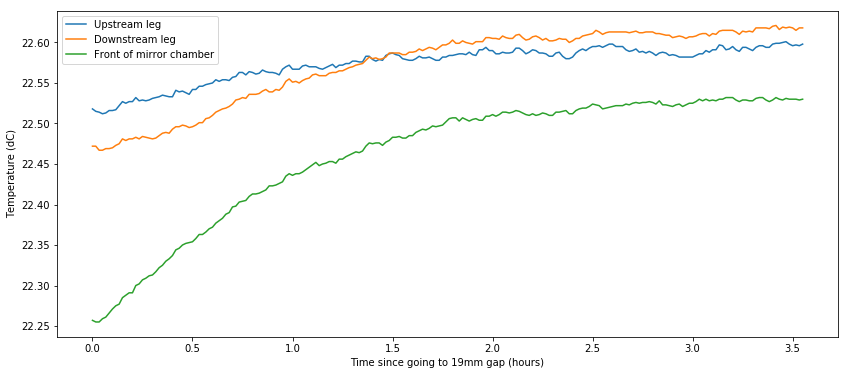

In [96]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(readingNumber,Tc[1],label="Upstream leg")
ax1.plot(readingNumber,Tc[2],label="Downstream leg")
ax1.plot(readingNumber,Tc[0],label="Front of mirror chamber")
plt.xlabel("Time since going to 19mm gap (hours)")
plt.ylabel("Temperature (dC)")
ax1.legend()
plt.show()

In [110]:

%matplotlib inline
font = {'size'   : 18}
matplotlib.rc('font', **font)


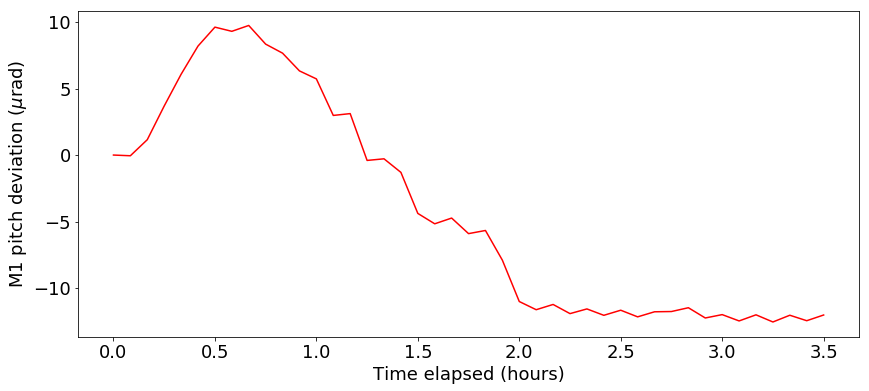

In [111]:
fig, ax1 = plt.subplots(figsize=(14,6))
offsetPitch = [ii-MeasurementSet[4]["M1"][0] for ii in MeasurementSet[4]["M1"]]
ax1.plot(MeasurementSet[4]["elapsedTime"],offsetPitch,'r-',label="Optimal M1 pitch")
ax1.set_ylabel("M1 pitch deviation ($\mu$rad)")
ax1.set_xlabel("Time elapsed (hours)")
#plt.legend()
plt.show()


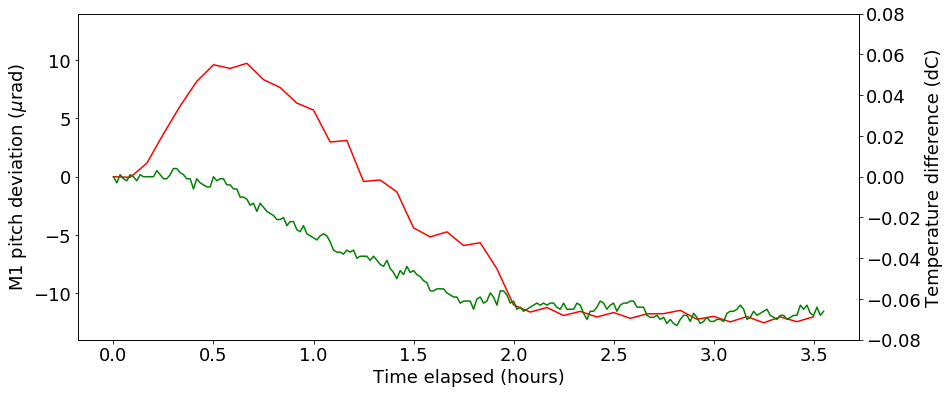

In [125]:
fig, ax1 = plt.subplots(figsize=(14,6))
offsetPitch = [ii-MeasurementSet[4]["M1"][0] for ii in MeasurementSet[4]["M1"]]
ax1.plot(MeasurementSet[4]["elapsedTime"],offsetPitch,'r-',label="Optimal M1 pitch")
ax1.set_ylabel("M1 pitch deviation ($\mu$rad)")
ax1.set_xlabel("Time elapsed (hours)")
#plt.legend()
ax1.set_ylim([-14,14])

ax2=ax1.twinx()
offsetLegTemp = [ii-TcDifference[0] for ii in TcDifference]
ax2.plot(readingNumber,offsetLegTemp,'g',label="Temperature difference (+--> upstream hotter)")
ax2.set_ylabel("Temperature difference (dC)")
ax2.set_ylim([-0.08,0.08])
plt.show()


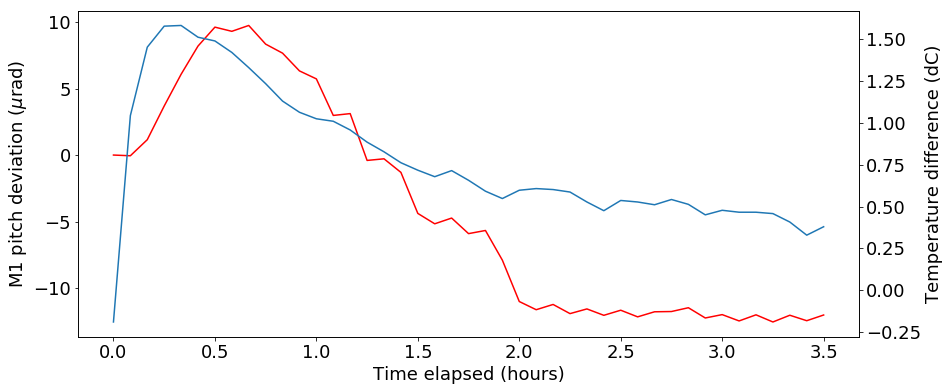

In [123]:
fig, ax1 = plt.subplots(figsize=(14,6))
offsetPitch = [ii-MeasurementSet[4]["M1"][0] for ii in MeasurementSet[4]["M1"]]
ax1.plot(MeasurementSet[4]["elapsedTime"],offsetPitch,'r-',label="Optimal M1 pitch")
ax1.set_ylabel("M1 pitch deviation ($\mu$rad)")
ax1.set_xlabel("Time elapsed (hours)")
#plt.legend()
#ax1.set_ylim([-14,14])

ax2=ax1.twinx()
M1TcDifference = [ii-jj for ii,jj in zip(MeasurementSet[4]["Tc1"],MeasurementSet[4]["Tc2"])]
ax2.plot(MeasurementSet[4]["elapsedTime"],M1TcDifference,label="M1 thermocouple 1")
ax2.set_ylabel("Temperature difference (dC)")
#ax2.set_ylim([-2,2])
plt.show()


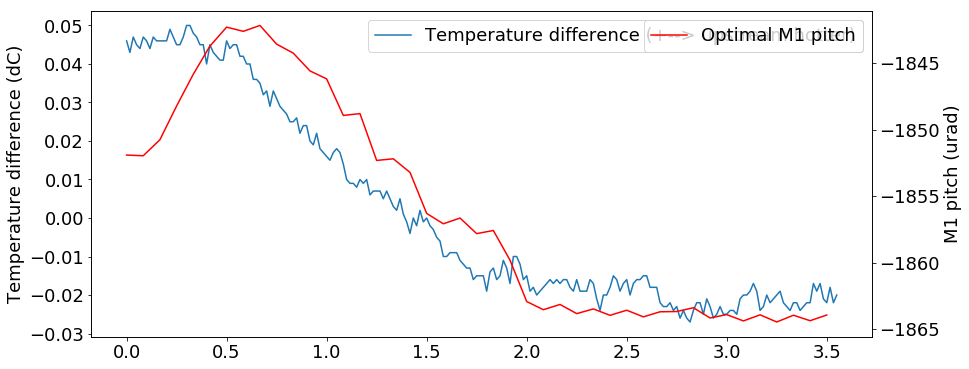

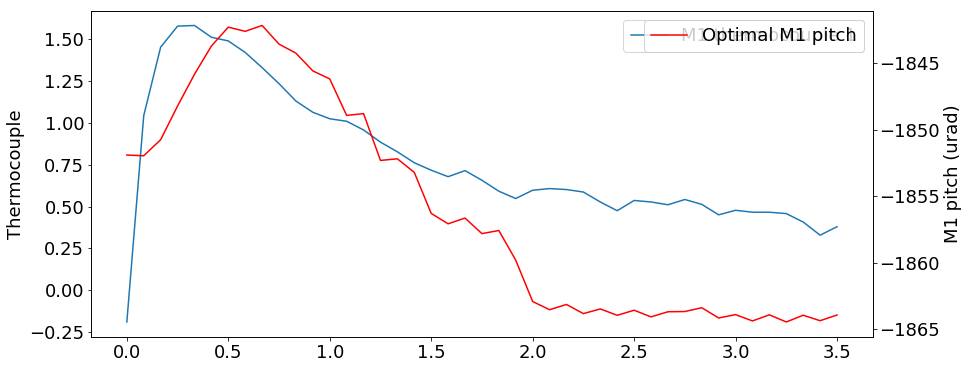

In [112]:
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(readingNumber,TcDifference,label="Temperature difference (+--> upstream hotter)")
ax1.set_ylabel("Temperature difference (dC)")
plt.legend()
ax2=ax1.twinx()
ax2.plot(MeasurementSet[4]["elapsedTime"],MeasurementSet[4]["M1"],'r-',label="Optimal M1 pitch")
ax2.set_ylabel("M1 pitch (urad)")
plt.legend()
plt.show()


fig, ax1 = plt.subplots(figsize=(14,6))
M1TcDifference = [ii-jj for ii,jj in zip(MeasurementSet[4]["Tc1"],MeasurementSet[4]["Tc2"])]
ax1.plot(MeasurementSet[4]["elapsedTime"],M1TcDifference,label="M1 thermocouple 1")
#ax1.plot(MeasurementSet[4]["elapsedTime"],MeasurementSet[4]["Tc2"],label="M1 thermocouple 2")
ax1.set_ylabel("Thermocouple")
plt.legend()
ax2=ax1.twinx()
ax2.set_ylabel("M1 pitch (urad)")
ax2.plot(MeasurementSet[4]["elapsedTime"],MeasurementSet[4]["M1"],'r-',label="Optimal M1 pitch")
plt.legend()
plt.show()


# Revisited 08.04.2019

Since we know that the M1 pitch drifts a little, let's come at this from the other side: If I don't do anything about it, what does this mean for my measurement stability?

To do this, I set gap 18mm/ phase 0 (hv=10.3eV) where the heat load is pretty severe. Starting from a cold mirror, quickly find the right M1 pitch then leave it there. Measure flux on the mesh as a function of time.

Here's an example (measured a little later) of how the intensity depends on M1 pitch:

Optimal M1 position=-1838.7
FWHM=25.4


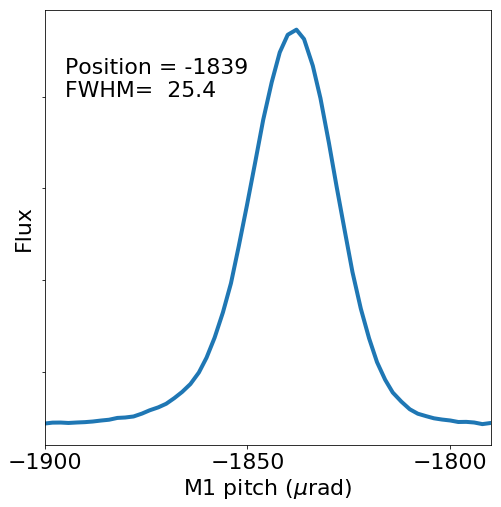

In [66]:
font = {'size'   : 22}
matplotlib.rc('font', **font)
scan = HDF5loadscan(path=data_folder/"(2019.04.08)_stability_wrt_M1Pitch.h5",scanIndex=58)
fig=plt.figure(figsize=(8,8))

scan['meshCurrent'] = [((ii*1)/1000) for ii in scan['b110a_ctl_em02_ch01']]

plt.plot(scan["m1_pitch"],scan["meshCurrent"],lw=4)

params = Parameters()
maxCurrent = max(scan['meshCurrent'])
minCurrent= min(scan['meshCurrent'])
maxCurrentIndex = scan['meshCurrent'].index(maxCurrent)
correctPitch =scan['m1_pitch'][maxCurrentIndex]

params.add('amplitude', 	value=maxCurrent, vary=True)
params.add('width', 	value=10,vary=True)
params.add('center', 	value=correctPitch,vary=True)
params.add('offset', 	value=minCurrent,vary=True)

out = minimize(residual, params,args=(scan['m1_pitch'], scan['meshCurrent']),method='leastsq')

fittedCurve=Gauss(out.params,scan['m1_pitch'])
print("Optimal M1 position={:.1f}".format(out.params['center'].value))
print("FWHM={:.1f}".format(out.params['width'].value) )       

#plt.plot(scan['m1_pitch'],fittedCurve,'--',lw=4,label='Gaussian fit')
plt.xlabel("M1 pitch ($\mu$rad)")
plt.ylabel("Flux")
plt.text(-1895,3e-11,"Position = {:.0f}\nFWHM=  {:.1f}".format(out.params['center'].value,out.params['width'].value))

ax = plt.gca()
ax.xaxis.set_ticks(np.arange(-1900, -1750, 50))
plt.xlim([-1900,-1790])
ax.set_yticklabels([])

plt.show()



If the M1 pitch drifts by 12urad, we will lose half the beam intensity

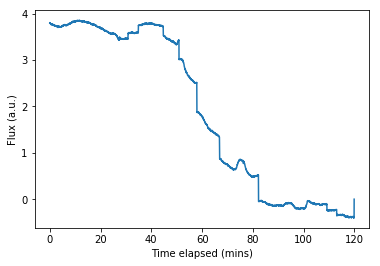

In [9]:
scan = HDF5loadscan(path=data_folder/"(2019.04.08)_stability_wrt_M1Pitch.h5",scanIndex=56)

fig=plt.figure()

scan['meshCurrent'] = [((ii*1e8)) for ii in scan['b110a_ctl_em02_ch01']]
scan['elapsed_mins'] = [ii/60 for ii in scan["dt"]]
plt.plot(scan["elapsed_mins"],scan["meshCurrent"])
plt.xlabel("Time elapsed (mins)")
plt.ylabel("Flux (a.u.)")
plt.show()

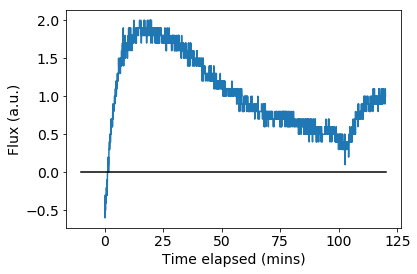

In [37]:
fig=plt.figure()
scan["M1_tc_diff"]=[ii-jj for ii,jj in zip(scan["B110AO01DIATCO01temperature"],scan["B110AO01DIATCO02temperature"])]

plt.plot(scan["elapsed_mins"],scan["M1_tc_diff"])
plt.plot([-10,120],[0,0],color='black')
plt.xlabel("Time elapsed (mins)")
plt.ylabel("Flux (a.u.)")
plt.show()

In [26]:
scan['dt'][-1]

7194.553747177124

In [27]:
7194/(120)

59.95

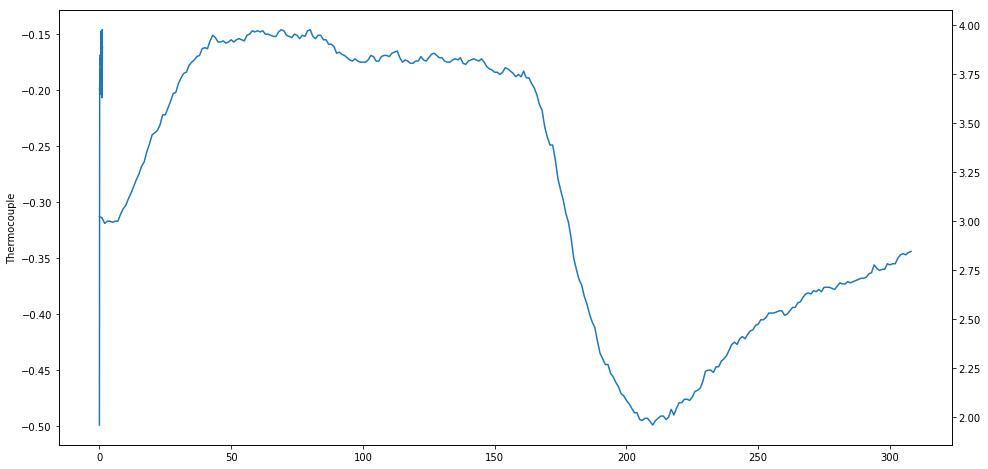

In [8]:
%matplotlib inline
fp=open("Data/thermocouples.csv",'r')
timeStamp=[]
Tc=[]
Tc.append([])
Tc.append([])
Tc.append([])
Tc.append([])

next(fp)
lineNumber=0
for line in fp:
    lineNumber+=1
    if lineNumber>46490 and lineNumber<46800:
        data=line.replace('"','').replace('\n','').split(',')
        for ii in range(4):
            Tc[ii].append(float(data[ii+1]))
fp.close()

readingNumber = [ii for ii in range(len(Tc[0]))]

Tc_diff = [ii-jj for ii,jj in zip(Tc[0],Tc[1])] 
fig, ax1 = plt.subplots(figsize=(16,8))
ax1.plot(readingNumber,Tc_diff)
#ax1.plot(readingNumber,Tc[2])
ax1.set_ylabel("Thermocouple")
#x1.set_xlim(0,13)
ax2=ax1.twinx()
ax2.plot(scan["elapsed_mins"],scan["meshCurrent"])
plt.show()

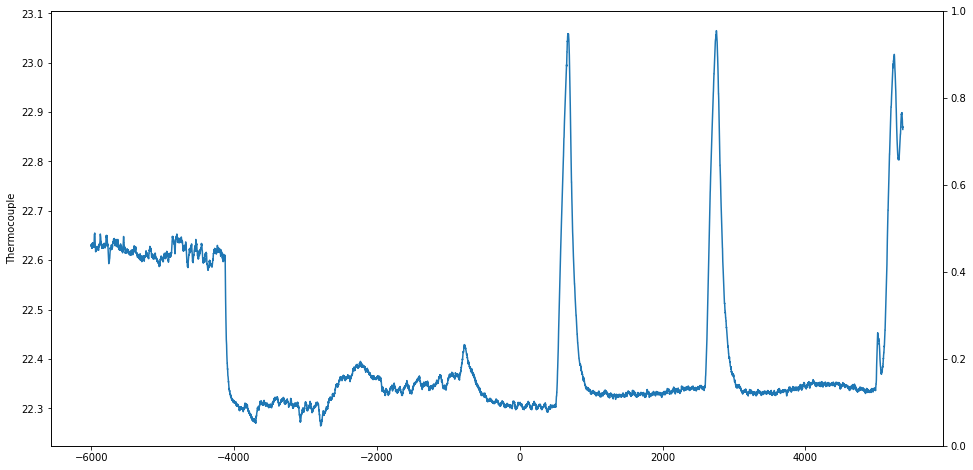

In [69]:
%matplotlib inline
fp=open("Data/thermocouples.csv",'r')
timeStamp=[]
Tc=[]
Tc.append([])
Tc.append([])
Tc.append([])
Tc.append([])

next(fp)
lineNumber=0
for line in fp:
    lineNumber+=1
    if lineNumber>4e4:
        data=line.replace('"','').replace('\n','').split(',')
        for ii in range(4):
            Tc[ii].append(float(data[ii+1]))
fp.close()

readingNumber = [ii-6e3 for ii in range(len(Tc[0]))]

Tc_diff = [ii-jj for ii,jj in zip(Tc[0],Tc[1])] 
fig, ax1 = plt.subplots(figsize=(16,8))
#ax1.plot(readingNumber,Tc_diff)
ax1.plot(readingNumber,Tc[2])
ax1.set_ylabel("Thermocouple")
#x1.set_xlim(0,13)
ax2=ax1.twinx()
#ax2.plot(scan["elapsed_mins"],scan["meshCurrent"])
plt.show()

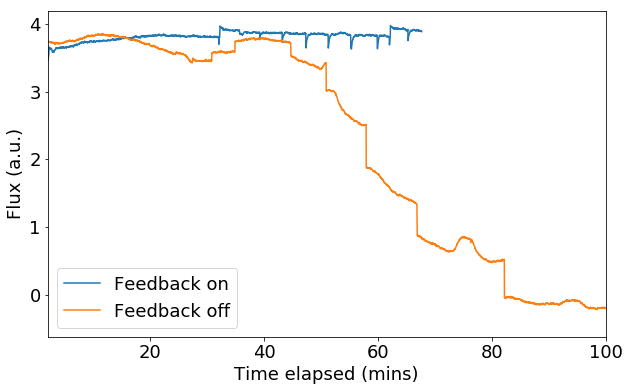

In [28]:
%matplotlib inline
font = {'size'   : 18}
matplotlib.rc('font', **font)
scan = HDF5loadscan(path=data_folder/"(2019.04.08)_stability_wrt_M1Pitch.h5",scanIndex=63)

fig=plt.figure(figsize=(10,6))

scan['meshCurrent'] = [((ii*1e8)) for ii in scan['b110a_ctl_em02_ch01']]
scan['elapsed_mins'] = [ii/60 for ii in scan["dt"]]
plt.plot(scan["elapsed_mins"],scan["meshCurrent"],label='Feedback on')

scan2 = HDF5loadscan(path=data_folder/"(2019.04.08)_stability_wrt_M1Pitch.h5",scanIndex=56)


scan2['meshCurrent'] = [((ii*1e8)) for ii in scan2['b110a_ctl_em02_ch01']]
scan2['elapsed_mins'] = [ii/60 for ii in scan2["dt"]]
plt.plot(scan2["elapsed_mins"],scan2["meshCurrent"],label='Feedback off')

plt.xlabel("Time elapsed (mins)")
plt.ylabel("Flux (a.u.)")
plt.xlim([2,100])
plt.legend()
plt.show()